# Single-particle tracking on a C-TRAP kymograph

version: July 15  |  Artur Kaczmarczyk  | github.com/arturrsl

David Rueda lab - Single-Molecule Imaging Group at LMS MRC/Imperial College London

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

This script can be used for processing and quantitative analysis of kymographs imported from a single .h5 file. 

Features of the script:
- Loading a kymograph from an .h5 file to the notebook's workspace and export into .tiff and .ong formats
- Image processing: cropping/filtering/compression
- Translation from pixel-position to genomic-position
- Co-plotting the force measurement from the optical tweezer
- Sub-pixel tracking algorithm that detects the trajectory of stationary and mobile molecules
- MSD, diffusion rate and speed analysis of translocating proteins

added: july 15: Standard error of the MSD linear regression fit


## Import the libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import sys                                  # for automated .h5 loading
import os
import statistics                           # for variance calculation 

from lumicks import pylake                  # main Lumicks package

#from skimage.io import imread              # loading tiff files, another way to plot kymographs other than through pylake commands

import peakutils                            # peak finder function
from peakutils.plot import plot as pplot

#from scipy.signal import find_peaks        # another method that detects peaks based on their prominence

import scipy as scipy  
from scipy import optimize
from scipy.optimize import curve_fit        # for Gaussian fitting 
      

%matplotlib inline

## Pre-set the properties of the rendered plots
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15
plt.rcParams.update({'figure.max_open_warning': 0}) 

# Load the .h5 file that contains the kymograph

The .h5 file (both 'kymo' and 'marker' type) should be located in the same folder as the current Jupyter Notebook.



In [3]:
# Import the .h5 filename saved in the current directory (the folder with the .h5 file and this Jupyter notebook)

folder = os.getcwd( )
filenames = os.listdir(folder)  
Filenames = []  
for filename in filenames:                      # select .h5 files only
    if filename[-3:] == '.h5':
        Filenames.append(filename)

        
name = str(Filenames[0])                        # in case there is more .h5 in your folder, change the index 0 to 1 or more
print("Imported file: " + name)
file = pylake.File(name)
print("The kymograph has the I.D. = " + str(list(file.kymos)))   # in case there is more kymographs saved in 1 .h5 file, there will be more than one ID

# Assign the Kymo I.D. as a variable
kymo_number = (list(file.kymos))   

# Inspect the content of the .h5 file
print(file)


Imported file: 20210330-225712 2nMBRCA2GFP_25nMR51647 Kymograph 25.h5
The kymograph has the I.D. = ['25']
File root metadata:
- Bluelake version: 1.6.13
- Description: 
- Experiment: 2nMBRCA2GFP_25nMR51647
- Export time (ns): 1617141432102798000
- File format version: 2
- GUID: {F0FBCAFC-049D-40DF-AF5D-EEC615973785}

Bead diameter:
  Template 1:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Size: 4260
  Template 2:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Size: 4260
Confocal diagnostics:
  Excitation Laser Blue:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Size: 1
  Excitation Laser Green:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Size: 1
  Excitation Laser Red:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Size: 1
Diagnostics:
  Microstage position X:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Size: 25
  Microstage position Y:
  - Data type: [('Timestamp', '<i8'), ('Value', '<f8')]
  - Siz

# Plot and save the kymograph with the force measurement 


In the following box, the data is accessed as Pylake's slices. Later on this convention is changed as the the 3D matrices with fluorescence intensities are loaded.

- In case there is more than one kymograph in the .h5 file, select the desired one by changing the "index" parameter ('0' is default for a file with a single kymograph)
- Specify the green/red/blue channel for plotting purposes in line 6 (with numbers 1,2,3, respectively). 
- Plotting different colors together will be possible further on
- Correct the brightness of the rendered PNG image (edit the "bright" parameter in line 20)

Maximal intensity in the selected channel: 118.0
Minimal intensity in the selected channel: 0.0
Background intensity in the selected channel: 4.0
Rows/columns: (310, 284)


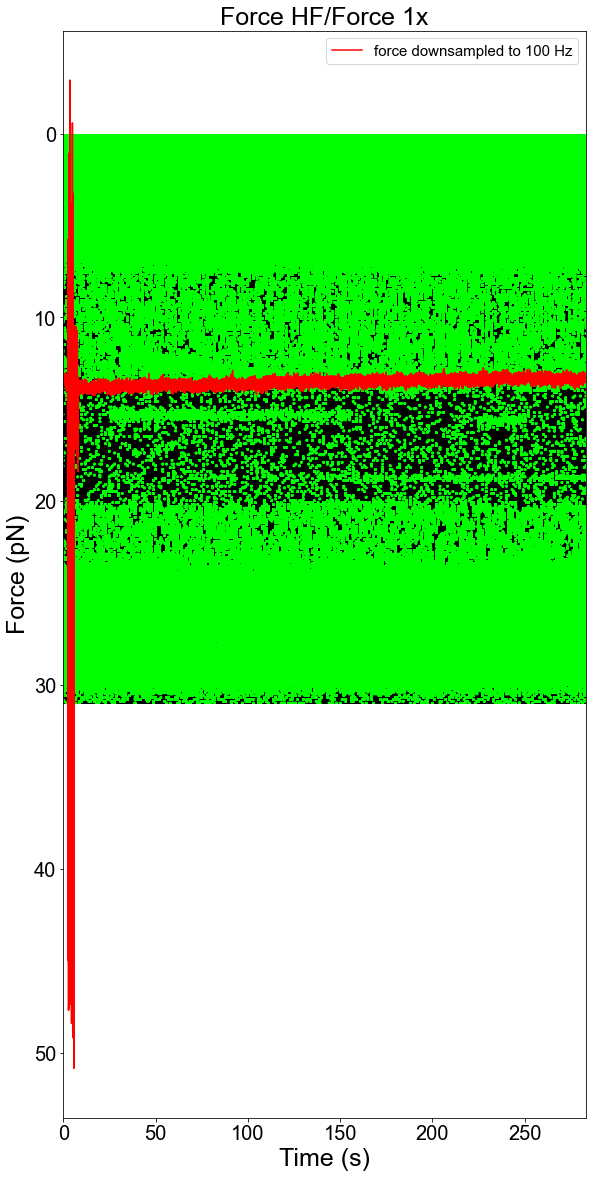

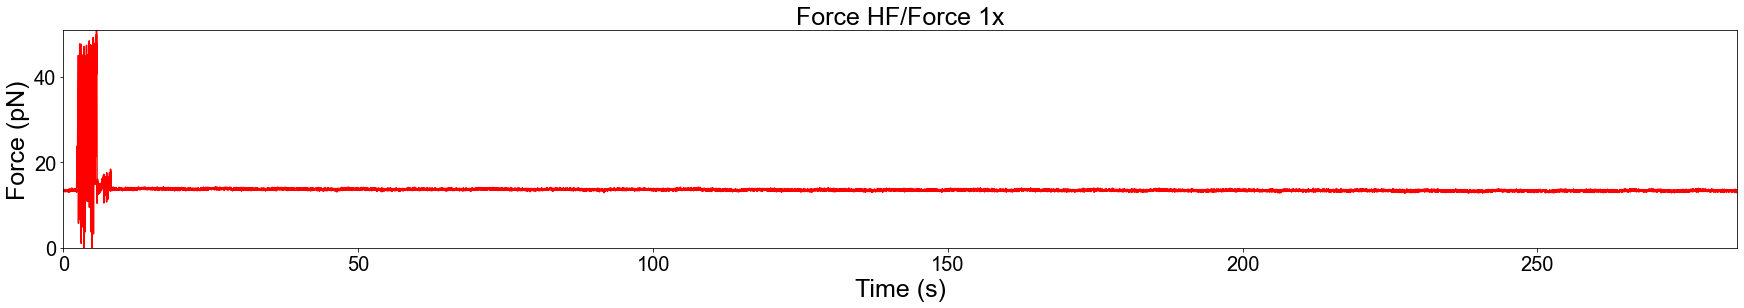

In [5]:
# Call the first kymograph of the imported .h5 file 
index = 0  #change index 0 to 1 or more to call for other kymographs stored in the current .h5 file
kymo = file.kymos[(kymo_number[index])]


# Choose the color [channel 1 - green, channel 0 - red, channel 3 - blue], 
# adjust the brightness, select the force channel and render the kymo 
channel = 2
bright = 0.001
string = 'Force 1x'
  
ax = plt.figure(figsize=(30,20))
if channel == 1:
    loaded_img = kymo.red_image[:]
    min_px = np.min(loaded_img)
    max_px = np.max(loaded_img)
    median_px = np.median(loaded_img)
    kymo.plot_red(vmax=bright*np.max(loaded_img))
elif channel == 2:
    loaded_img = kymo.green_image[:]
    min_px = np.min(loaded_img)
    max_px = np.max(loaded_img)
    median_px = np.median(loaded_img)
    kymo.plot_green(vmax=bright*np.max(loaded_img))
elif channel == 3:
    loaded_img = kymo.blue_image[:]
    min_px = np.min(loaded_img)
    max_px = np.max(loaded_img)
    median_px = np.median(loaded_img)
    kymo.plot_green(vmax=bright*np.max(loaded_img))
else:
    loaded_img = kymo.rgb_image[:]
    min_px = np.min(loaded_img)
    max_px = np.max(loaded_img)
    median_px = np.median(loaded_img)
    kymo.plot_rgb(vmax=bright*np.max(loaded_img))

# Get a sense of the pixel values in the kymos. If the image is too dimmed, decrease the "bright" parameter

print('Maximal intensity in the selected channel: ' + str(max_px))

print('Minimal intensity in the selected channel: ' + str(min_px))
print('Background intensity in the selected channel: ' + str(median_px))
print('Rows/columns: ' + str(loaded_img.shape))


## Images will be saved as high-res PNGs with the date and the image's details
plt.savefig('Kymo_'+  (kymo_number[index])+'_' + str(name[0:15])  + '.png', dpi=300, bbox_inches='tight')


# Co-plot the (downsampled) force measurement
[rows,columns] = loaded_img.shape

timestamps = kymo.timestamps/1e9
kymo_time = (timestamps[0,-1]-timestamps[0,0])  # time in seconds


forcex = file['Force HF'][string]    # force in the x direction (pN)
sample_rate = forcex.sample_rate         # downsampling the force, nanostage position and time
downsampled_rate = 100 # Hz
forcex_downsamp = forcex.downsampled_by(int(sample_rate/downsampled_rate))
#forcex.plot(label="Original")           # raw force data without downsampling
forcex_downsamp.plot(color='r',label="force downsampled to 100 Hz")

time = forcex.timestamps/1e9             # time traces (seconds)
time = time - time[0]
time_downsamp = forcex_downsamp.timestamps/1e9
time_downsamp = time_downsamp - time_downsamp[0]

plt.ylabel('Force (pN)')
plt.xlim([0,int(kymo_time)])
plt.xticks(np.arange(0, int(kymo_time), 50))
#plt.ylim([0,70])
plt.legend()

plt.savefig('Force_' + (kymo_number[index]) + '_' + str(name[0:15]) +  '.png', dpi=300, bbox_inches='tight')


#Plot force separately
plt.figure(figsize=(30,4))

#forcex.plot(label="Original")
forcex_downsamp.plot(color='r')
plt.ylabel('Force (pN)')
plt.xlim([0,max(time)])
plt.ylim([0,max(forcex_downsamp.data)])
plt.savefig('ForceOnly_' + (kymo_number[index]) + '__' + str(name[0:15]) +  '.png', dpi=300, bbox_inches='tight')
np.savetxt('Force_'+str(name[0:15]) + '_Kymo' + (kymo_number[index]) + '.csv',np.c_[time_downsamp, forcex_downsamp.data], delimiter=",") # exports the entire green trace


## Export kymo as .tiff

In [5]:
kymo.save_tiff('Tiff_Kymo_' + (kymo_number[index]) +'__' + str(name[0:15])+ '.tiff')


## Image processing functions



In [21]:
## Filters
#  Horizontal Filter
def horizontal_med_filter(rgb_image, size): 
    filt_image = rgb_image[:]
    w = rgb_image.shape[1]  #size of x (pixels?)
    n = 0
    
    for y in range(0,w):
        filt_image[:,y,:] = np.median(rgb_image[:,n:n+size], axis=1) 
        n += 1
    
    return(filt_image)

#   Vertical Filter
def vertical_med_filter(rgb_image, size): 
    filt_image = rgb_image[:]
    h = rgb_image.shape[0]
    n = 0
    
    for y in range(0,h):
        filt_image[y,:,:] = np.median(rgb_image[n:n+size,:], axis=0)
        n += 1
    
    return(filt_image)

#   Sum Horizontal
def sum_horizontal(rgb_image, nlines):
    image_hsum = rgb_image[:]
    w = rgb_image.shape[1]  #size of x (pixels?)
    n = 0
    
    for y in range(0,w):
        image_hsum[:,y,:] = rgb_image[:,n:n+nlines,:].sum(axis=1)
        n += nlines
    
    image_hsum = image_hsum[:,:int(w/nlines),:]
    
    return(image_hsum)

#   Sum Vertical
def sum_vertical(rgb_image, nlines):
    image_vsum = rgb_image[:]
    h = rgb_image.shape[0]
    n = 0
    
    for y in range(0,h):
        image_vsum[y,:,:] = rgb_image[n:n+nlines,:,:].sum(axis=0)
        n += nlines
    
    image_vsum = image_vsum[:int(h/nlines),:,:]
    
    return(image_vsum)


def process_image(rgb_image, level_hfilter, level_vfilter, level_hsum, level_vsum):
    image_hf = horizontal_med_filter(rgb_image, level_hfilter)
    image_hf_vf = vertical_med_filter(image_hf, level_vfilter)
    image_hf_vf_sh = sum_horizontal(image_hf_vf, level_hsum)
    image_hf_vf_sh_vh = sum_vertical(image_hf_vf_sh, level_vsum)
    return(image_hf_vf_sh_vh)

## Adjust contrast and filter the image

Here, the script creates a 3D matrix image_rgb and it will no longer use the Pylake slices commands to access fluorescence data.

Pixel size = 0.1 um/pixel


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Line time =  1000.0 ms
Pixels per line = 310 pixels
Pixel time = 3.2 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


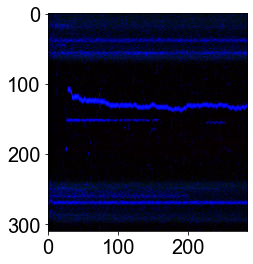

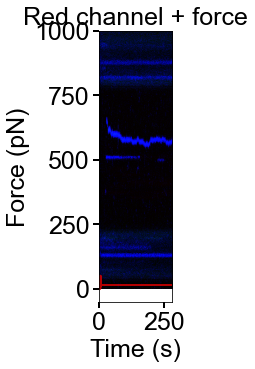

In [22]:
## Load Image as a 3D matrix
kymo = file.kymos[(kymo_number[index])]
image_rgb = []
image_rgb = kymo.rgb_image[:] 

print('Pixel size = ' + str(kymo.pixelsize_um[0]) + ' um/pixel') 
print('Line time =  ' + str(kymo.line_time_seconds*1000) + ' ms') 
print('Pixels per line = ' + str(kymo.pixels_per_line) + ' pixels') 
pixel_time = kymo.line_time_seconds/kymo.pixels_per_line
#pixel_time = 0.1 #second
print('Pixel time = ' + str(round(pixel_time*1000,1)) + ' ms') 



## Edit kymo color intensity and image dimensions

# Define base colour levels
level_red = 0.0002
level_green = 0.002
level_blue = 0.1

# Define Filter and Line Summing (keep 1 for no filterring)

level_hfilter = 1
level_vfilter = 1
level_hsum = 1
level_vsum = 1

# Adjusted colour levels
level_red  /= (level_hsum*level_vsum)
level_green /= (level_hsum*level_vsum)
level_blue /= (level_hsum*level_vsum)

#print(image_rgb[:,3,1])



## Adjust colour balance
image_rgb[:,:,0] = (image_rgb[:,:,0]*level_red)
image_rgb[:,:,1] = image_rgb[:,:,1]*level_green
image_rgb[:,:,2] = image_rgb[:,:,2]*level_blue
#print(image_rgb[:,300,1])

processed_image = process_image(image_rgb, level_hfilter, level_vfilter, level_hsum, level_vsum)


# Plot the squeezed kymograph 

#plt.figure(figsize=(20,10))
plt.imshow(processed_image[:,:,:])
plt.savefig('KymoFrame_'+ (kymo_number[index])+ '__' +str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')


# Plot the squeezed kymograph with appropriate time scale 
line_time_edited = time_downsamp[-1]/image_rgb.shape[1]
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(processed_image[:,:,:],extent=[0,kymo_time,0,rows*pixel_time*1000])
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
#ax.set_xlabel("Time (s)", fontsize=25)
#ax.set_ylabel("Position (μm)",  fontsize=25)
#ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)

forcex_downsamp.plot(color='r', alpha=0.7)
plt.xlim([0,max(time)])
#plt.ylim([0,max(forcex_downsamp.data)])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Force (pN)")
ax.set_title('Red channel + force')

#fig, ax = plt.subplots(figsize=(6,6))
#plt.imshow(processed_image, cmap=plt.cm.Reds, interpolation='none', extent=[0,line_time_edited[-1]])
#plt.set_aspect(2) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio

plt.savefig('KymoTime_' + (kymo_number[index]) + '__' +str(name[0:15]) +  '.png', dpi=300, bbox_inches='tight')


In [7]:
# Select the start and end point of the kymograph (in seconds)

start = 0
end = 150

# Activate the two lines below if no slicing is required
#start = [0]
end = int(kymo_time)-1 # subtracting 1 sec in case the rounding approximates to the +1 larger number

os.makedirs(str(start)+'_'+str(end)+'s_Window_PositionAnalysis')  # create folder

FileExistsError: [Errno 17] File exists: '0_282s_Window_PositionAnalysis'

## Plot cummulative intensity of the kymograph

The intensity of the fluorescent signal is scanned along vertical lines of the kymograph. The intensity profiles in the selected time window are summed and normalized. Finally, a cumulative intensity profile is plotted.  


Line time = 996 ms.


NameError: name 'image_rgb' is not defined

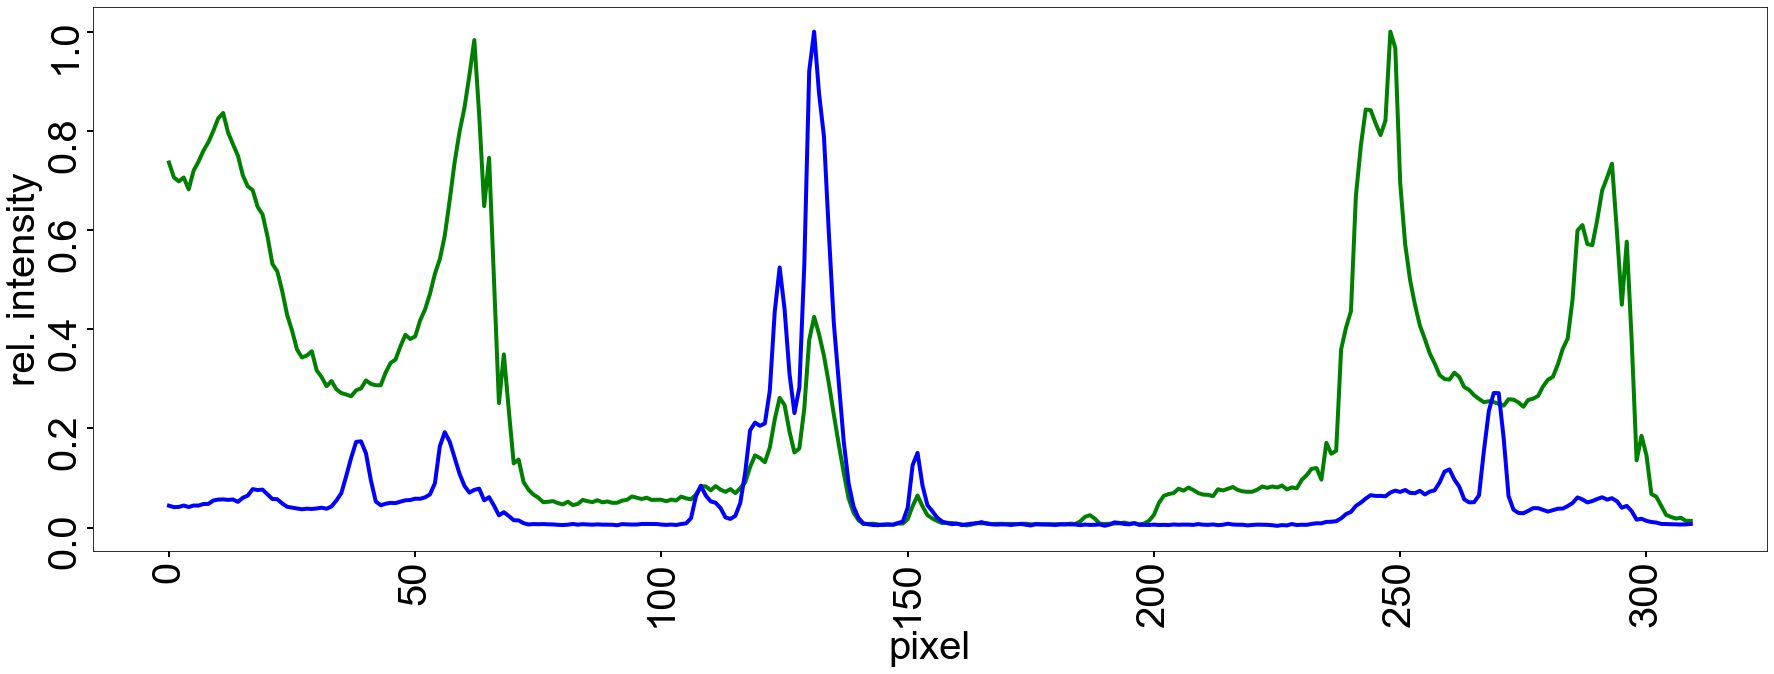

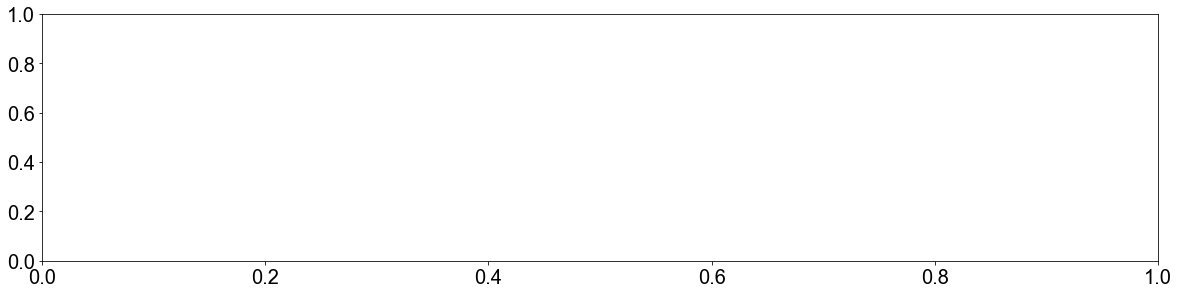

In [10]:
# Check the scanning time per 1 line of the kymograph

line_time = kymo_time/loaded_img.shape[1]

# line_time = time_downsamp[-1]/loaded_img.shape[1]
print('Line time = ' + str(round(line_time*1000)) + ' ms.')


cut_left = int(start/line_time)   # translate the time window into pixel domain
cut_right = int(end/line_time)

                

# Intensity per line

loaded_img_sum = loaded_img[:,cut_left:cut_right].sum(axis=1)          
#loaded_img_sum = loaded_img[:,:].sum(axis=1)                # no slicing
norm_loaded_img_sum = loaded_img_sum/np.amax(loaded_img_sum)

beads_img = kymo.blue_image
beads_img_sum = beads_img[:,cut_left:cut_right].sum(axis=1)   
#beads_img_sum = beads_img[:,:].sum(axis=1)                  # no slicing
norm_beads_img_sum = beads_img_sum/np.amax(beads_img_sum)


from scipy.signal import savgol_filter  ## when the blue bead centers are missing
norm_beads_img_sum_smooth = savgol_filter(norm_beads_img_sum,101, 3)

# Plotting together 2 channels (data + beads centers in blue), normalized to the highest value of the profile at given channel 

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(norm_loaded_img_sum, 'g',norm_beads_img_sum, 'b',linewidth = '4' )
plt.xticks(rotation=90)
plt.yticks(rotation=90)
ax.tick_params(direction='out', length=6, width=2, labelsize= 40, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("pixel", fontsize=40)
ax.set_ylabel("rel. intensity", fontsize=40)


# Plot and save the chopped images

fig = plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.imshow(image_rgb[:,cut_left:cut_right,channel])
plt.title('data')
plt.xlabel("line number")
plt.ylabel("pixel")

plt.subplot(2,1, 2)    
plt.imshow(image_rgb[:,cut_left:cut_right,2])
plt.title('centers of the beads')
plt.xlabel("line number")
plt.ylabel("pixel")

#os.makedirs(str(start)+'_'+str(end)+'sec_Window_PositionAnalysis')  # create folder
plt.savefig(str(start)+'_'+str(end) +'s_Window_PositionAnalysis'+ '/'+'Pixels_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) +'__' +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
print(image_rgb.shape)

# Translate pixels to genomic position

The script needs here the peak detection package (download 'peakutils' library).

1. Type the necessary information to translate pixel position into a genomic position (pixel size, bead size, DNA contour length).
2. Optionally, change the thresholds in the line corresponding with peak detection.
3. Select "flip" betwen 0 or 1 in case you need to reverse the orientation of the DNA tether (plotting of the peaks doesn't work well when the lengths are flipped, but the calculation of the position is OK)

pixel size = 100.0
Average force in the plotted window: 13.76 pN
DNA extension at this force: 15.97 um.
Peaks in the green channel are on positions [48.22510426] kB
Peaks in the blue channel are on positions [ 39  56 119 124 131 152 260 269] kB


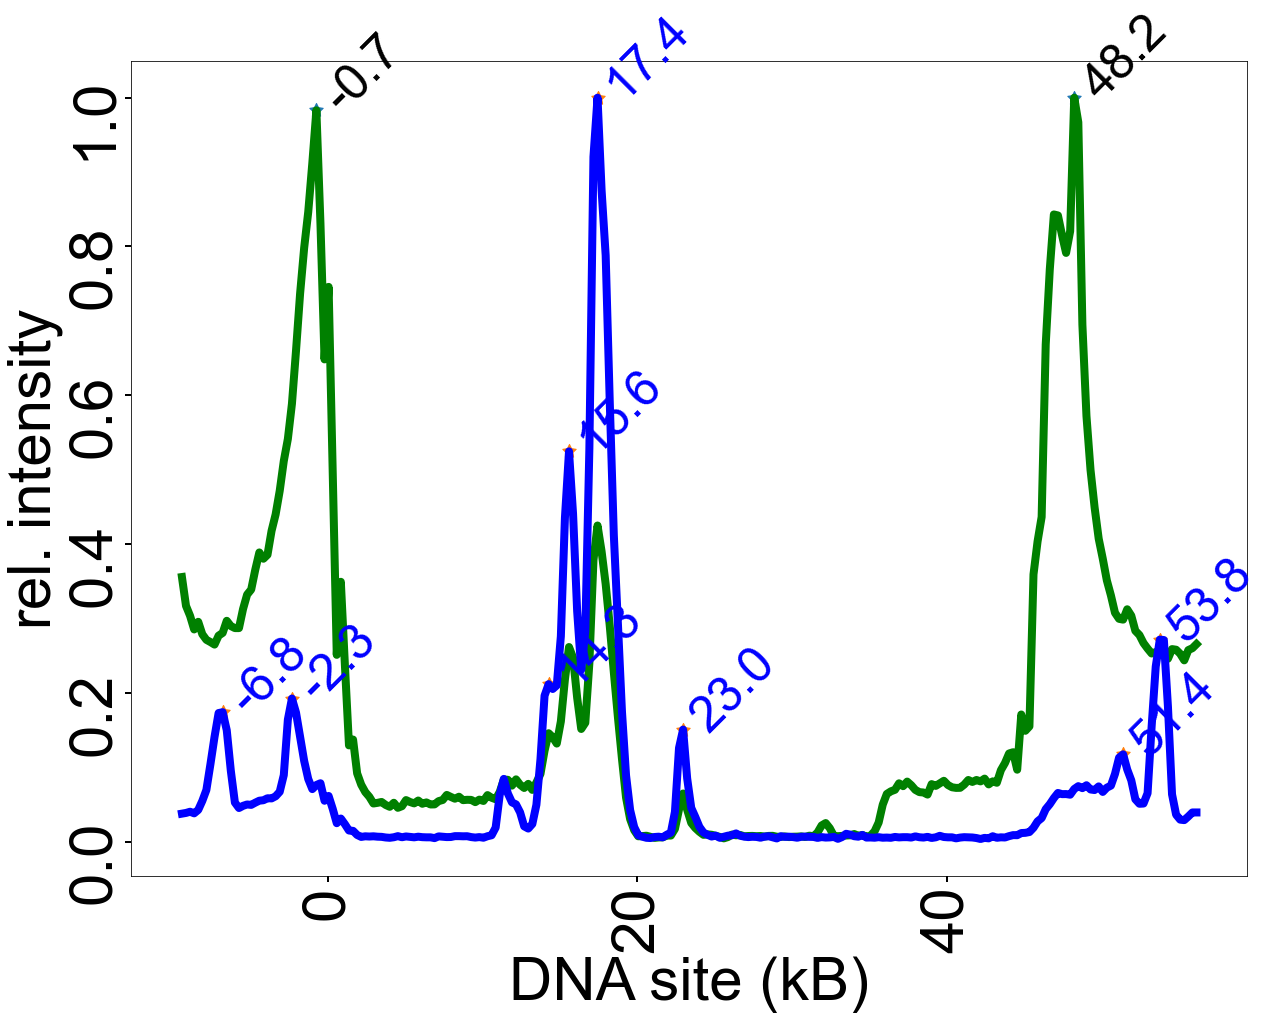

In [19]:
# TYPE THE PARAMETERS CHARTACTERIZING THE EXPERIMENTAL SETUP

# Pixel size (nm/pixel)
ps = kymo.pixelsize_um[0]*1000
print(str('pixel size = ')+str(ps))

# Bead diameter (nm)
bs = 4400

# length per base pair (nm)
bp = 0.34

# Number of additional kymograph lines next to the bead center peak
offset = 10  

# Tether orientation? Type "1" to reverse it
flip = 0     

# DNA contour length (nm) [ds lambda DNA: 16490 nm]
ds = 16490

# Estimate the effective tether length knowing the force and fitting to the WLC model

zoom_force = forcex_downsamp[(str(start)+'s'):(str(end)+'s')]  # force exerted on the DNA in the analyzed part of the kymograph
zoom_force_mean = np.mean(zoom_force.data)
print('Average force in the plotted window: ' + str(np.round(zoom_force_mean,2)) + ' pN')

def eWLC(force, L0):      #Lp is the persistence length in micrometers (0.045 for DNA)
    
    F = force
    Lp = 45        # persistence length (nm)
    kB = 1.38e-2   # Boltzmann constant
    T = 297        # temperature (K)
    S = 1500       #stretching modulus (pN)
    C = kB * T / (Lp)    
    d = L0 - ((L0/2)*np.sqrt(C/F)) + (F*L0/S)

    return(d)


ds_mean = eWLC(zoom_force_mean, ds)   # effective tether length

print('DNA extension at this force: ' + str(np.round(ds_mean/1000,2)) + ' um.')


# DEFINE THE BACKGROUND LEVEL (peaks with relative intensities below this threshold will not be detected)

threshold_data = 0.9
threshold_bead = 0.1


# Generate an array with pixel indexes where a peak was found
indexes_bead = []
indexes_bead = peakutils.indexes(norm_beads_img_sum, threshold_bead, min_dist=3)  # peaks with bead centers  
peaks_bead = norm_beads_img_sum[indexes_bead]

indexes_data = []
indexes_data = peakutils.indexes(norm_loaded_img_sum, threshold_data, min_dist=3) # the analyzed signal
peaks_data = norm_loaded_img_sum[indexes_data]


# Zooming to the region in between two blue peaks 
roi_left = indexes_bead[0]-offset    
roi_right = indexes_bead[-1]+offset   
norm_loaded_img_sum_cut = norm_loaded_img_sum[roi_left:roi_right]
norm_beads_img_sum_cut = norm_beads_img_sum[roi_left:roi_right]


# Linear interpolation of line indexes into length in nanometers and then into DNA bases

xp = [roi_left,roi_right]
fp = [-0.5*bs-offset*ps, ds_mean+0.5*bs+offset*ps]
lines = np.arange(roi_left, roi_right,1)

position_beads = np.interp(indexes_bead, xp, fp)/bp/1000    # interpolation 
position_data = np.interp(indexes_data, xp, fp)/bp/1000    # interpolation 
position = np.interp(lines, xp, fp)/bp/1000


if flip == 1:
    position = position[::-1] 
    position_data  = 48.5-position_data

    

    
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(position, norm_loaded_img_sum_cut, 'g',position, norm_beads_img_sum_cut, 'b', linewidth=8.0)


# Label the peaks
ax.scatter(position_data,peaks_data, marker=(5, 1), s=200)
for i, txt in enumerate(position_data):
    txt = str(np.round_(position_data[i],decimals=1))
    ax.annotate(txt, (position_data[i], peaks_data[i]),rotation=45, size=50)

ax.scatter(position_beads, peaks_bead, marker=(5, 1), s=200)
for i, txt in enumerate(position_beads):
    txt = str(np.round_(position_beads[i],decimals=1))
    ax.annotate(txt, (position_beads[i], peaks_bead[i]),rotation=45, size=50,color='b')

ax.tick_params(direction='out', length=6, width=2, labelsize= 60, grid_color='r', grid_alpha=0.5)
#ax.legend(['fluophore position ','centers of the beads'], fontsize=50, frameon=False)
ax.set_xlabel("DNA site (kB)", fontsize=60)
ax.set_ylabel("rel. intensity", fontsize=60)
plt.xticks(rotation=90)
plt.yticks(rotation=90) 



# Remove peaks which are not on the tethered DNA
position_data2 =  position_data[position_data>0]       # eliminating the green peaks coming from the bead1
position_data3 =  position_data2[position_data2<48.5]  # eliminating the green peaks coming from the bead2

#if flip == 1:
    #position_data3 = 48.500 - position_data3
    
print('Peaks in the green channel are on positions ' + str(position_data3) + ' kB' )
print('Peaks in the blue channel are on positions ' + str(indexes_bead)+ ' kB' )


plt.savefig(str(start)+'_'+str(end) +'s_Window_PositionAnalysis'+ '/'+'Intensity_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) + '_' +str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
np.savetxt(str(start)+'_'+str(end) +'s_Window_PositionAnalysis'+ '/'+'Peaks_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) + '_' +str(name[0:15])+ '.csv', position_data3, delimiter=",")    # exports the peak position
np.savetxt(str(start)+'_'+str(end) +'s_Window_PositionAnalysis'+ '/'+'Intensities_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) + '_' +str(name[0:15])+ '.csv',np.c_[position, norm_loaded_img_sum_cut], delimiter=",") # exports the entire green trace
np.savetxt(str(start)+'_'+str(end) +'s_Window_PositionAnalysis'+ '/'+'Beads_Peaks_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) + '_' +str(name[0:15])+ '.csv', position_beads, delimiter=",")    # exports the peak position
np.savetxt(str(start)+'_'+str(end) +'s_Window_PositionAnalysis'+ '/'+'Beads_Intensities_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) + '_' +str(name[0:15]) +'.csv',np.c_[position, norm_beads_img_sum_cut], delimiter=",") # exports the entire green trace


#plt.savefig(str(name[0:15]) +' SELECTION_' + str(start) + 's_' + str(end) + 's_Kymo' + (kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')

# Single-particle detection in time

Locating the position (and movement) of fluoresently labeled molecule on the kymograph.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FileExistsError: [Errno 17] File exists: 'Single-particle tracking'

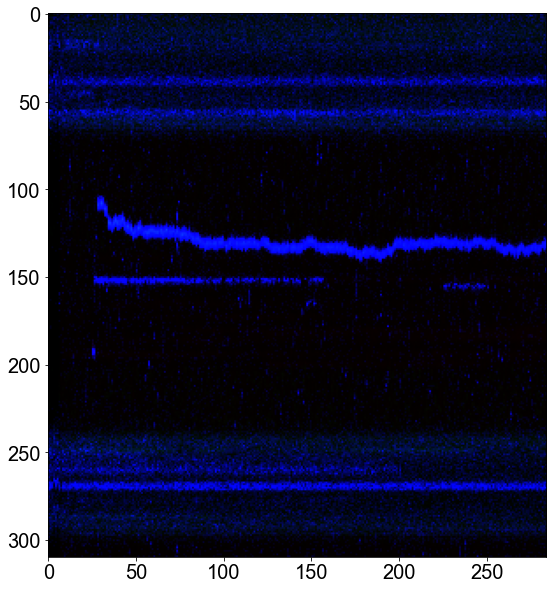

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(processed_image[:,:,:])
os.makedirs('Single-particle tracking') 

## Crop the area of interest, estimate background, generate an additional processed image for the single-particle tracker

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Line time = 0.9964788732394366s.
Line_time after images summing = 0.9964788732394366s.


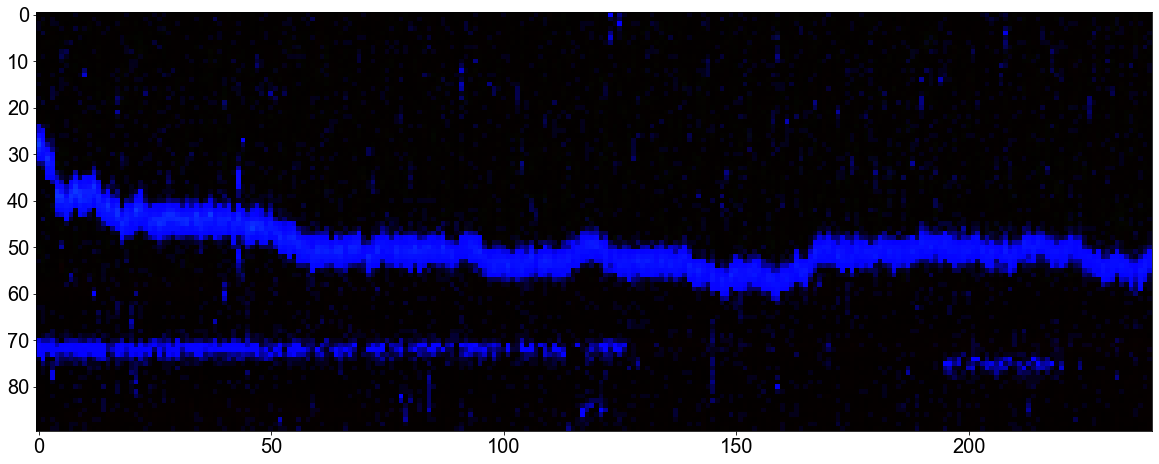

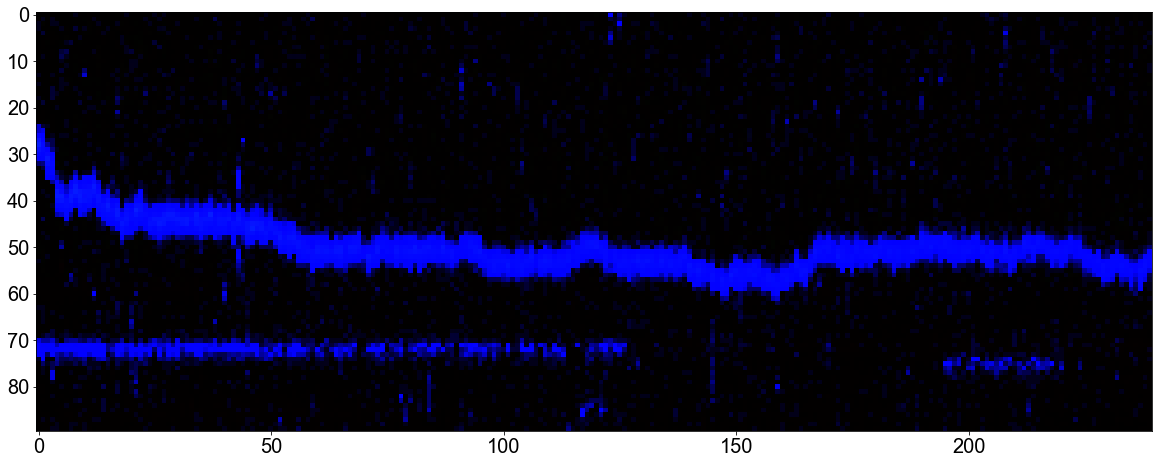

In [24]:
##### Crop the image (LOOK AT THE ORIGINAL IMAGE COORDINATES, NOT THE SQUEEZED ONE)

crop_top = 80
crop_bottom = 170
crop_left =30
crop_right = 270


image_rgb_select = image_rgb[crop_top:crop_bottom,crop_left:crop_right,:]


plt.figure(figsize=(20,10))
plt.imshow(image_rgb_select)




# Call the raw image again in case something is messed up due to previous median filterring and squeezing
index = 0 #change index 0 to 1 or more to call for other kymographs stored in the current .h5 file



# Choose the color [channel 1 - green, channel 2 - red, channel 3 - blue]
channel = 1

if channel == 1:
    loaded_img = kymo.red_image[:]  
elif channel == 2:
    loaded_img = kymo.green_image[:]
else:
    loaded_img = kymo.blue_image[:]
    
#image_rgb = kymo.rgb_image[:]   

#plt.imshow(loaded_img_crop[:,cut_left:cut_right])

# Define base colour levels
level_red = 0.0001
level_green = 0.001
level_blue = 0.1

# Define Filter and Line Summing (keep 1 for no filterring)

level_hfilter = 1
level_vfilter = 1
level_hsum = 1
level_vsum = 1
#level_vsmooth = 3

#level_hsmooth = 3

index = 0
kymo2 = file.kymos[(kymo_number[index])]

image_rgb2 = kymo2.rgb_image[:] 

plt.savefig('Single-particle tracking' +'/'+'NonTracked_RAW_' + 'Kymo' + (kymo_number[index]) +'__' +str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')


line_time = kymo_time/loaded_img.shape[1]


# Adjusted colour levels
level_red  /= (level_hsum*level_vsum)
level_green /= (level_hsum*level_vsum)
level_blue /= (level_hsum*level_vsum)


## Adjust colour balance
image_rgb2[:,:,0] = image_rgb2[:,:,0]*level_red
image_rgb2[:,:,1] = image_rgb2[:,:,1]*level_green
image_rgb2[:,:,2] = image_rgb2[:,:,2]*level_blue
#line_time_edited = time_downsamp[-1]/image_rgb.shape[1]

processed_image2 = process_image(image_rgb2[crop_top:crop_bottom,crop_left:crop_right,:], level_hfilter, level_vfilter, level_hsum, level_vsum)
#processed_image2 = image_rgb[110:265,10000:,:]


plt.figure(figsize=(20,10))
plt.imshow(processed_image2)
#plt.savefig(str(name[0:15]) + '_KymoGraph_Frame_Cut_' + (kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/'+'NonTracked_' + 'Kymo' + (kymo_number[index]) +'__' +str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')

print('Line time = '+ str(line_time) + 's.')
print('Line_time after images summing = '+ str(line_time*level_hsum) + 's.')

## Single particle tracking algorithm

This function exports trajectories of the fluorescent molecules. By probing each time-frame (averaged by 3-frame moving window), the scripts checks proximity between peaks within the consecutive frames.

Pixels that are not farther than a certain 'step' threshold are considered as elements of a single trajectory ('ridge'). Selected pixels (and a few neighboring pixels from the same time-frame) are then fitted to Gaussian to obtain subpixel resolution of the detection.

The function exports the 2x2D list of the detected ridges and the corresponding time-frames.


Input parameters:
- img_crop_raw - 2D array containing photon counts (single color), unprocessed
- img_crop - 2D array containing photon counts (single color) but might have been filterred (the size must remain the same as the original) NOTE: since the 3-frame moving window has been introduced to the analysis, there is no need to pre-process the image prior to single-particle tracking. Effectively, "img_crop" imports the raw image as well. But I keep this option for some difficult kymos
- thres_peak - threshold for the peak finder function, minimal relative intensity that can be considered as a peak (between 0-1)
- step - the maximal number of pixels that a single molecule can move within 1 time-frame
- length - the minimal length of the ridge (allows to remove the artefacts)
- N - number of pixels around the detected peak to be considered for Gaussian fitting



In [25]:
## version 16 June 2021


def track_kymo(img_crop_raw, img_crop, thres_peak, step, length, N):

    
    kymo_cut_processed = []
    kymo_cut_processed = img_crop   # image that have been optionally median-filterred or "squeezed" 
    
    kymo_cut = []
    kymo_cut = img_crop_raw         # raw kymo, only intensity is multiplied
    
    [a,b] = kymo_cut.shape

    ridges = [] 
    ridge_found = []
    ridges_found_2D = []
    ridges_found_index_2D = []

    ###########################
             
    # function that searches the value in a neighboring array that is the nearest to a defined value
    
    def find_nearest(array, value):             
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]
    
    # Gaussian function
    
    def _1gaussian(x, amp1,cen1,sigma1):
        return amp1*(np.exp(-0.5*(((x_fit_data_Gauss-cen1)/sigma1)**2)))
        #return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_fit_data-cen1)/sigma1)**2)))
    
    
    ###########################
    
    # Scan each column of the kymograph and search for peaks ('thres' parameter is one of the function's input)
    # To avoid blank frames, a moving window of 3 frames is used and the "summed" image is the smoothed with Savitzky-Goliat filter. 
    # Note: smoothing is performed only to detect the peaks. The final signal detection is done on raw pixel counts.
    
    
    from scipy.signal import savgol_filter
    
    pos_smooth = []
    SavGolwindow = 11 ## filter window, use odd values
    background = []
    
    for i in range (3,b-10):   #scan every time frame; the last 10 columns of the kymo are ignored
        
           
        kymo_cut_window = []
        kymo_cut_window = kymo_cut_processed[:,i-1:i+2].sum(axis=1)  # moving window of 3 frames
        background = np.mean(kymo_cut_window)
        kymo_cut_window = kymo_cut_window - background  # subtract background
        
        kymo_cut_smooth = savgol_filter(kymo_cut_window,SavGolwindow, 3) # smooth the summed frame
        
        peaks = peakutils.indexes(kymo_cut_smooth, thres_peak, min_dist=3)  # detect peaks
        #peaks = peakutils.indexes(kymo_cut_processed[:,i], thres_peak, min_dist=2)  # use when you  want to scan each frame individually, without filtering
        
        peaks_list = peaks.tolist()
        ridges.append(peaks_list)   
        # now each element of the list contains a sublist of the peaks found in each time-frame 
        

  
        
    fig, ax = plt.subplots(figsize=(28, 4))   
    plt.imshow(kymo_cut)


    for i in range(3,b-15):    #  scan every time frame; the last columns of the kymo are ignored
    
        if ridges[i] != []:                       # do something unless there is zero peaks in the current time-frame

            for j in range (0,len(ridges[i])):    # if the current time-frame has N peaks, there is a chance there are N ridges to detect
                
                ridges_array = []
                ridges_array_index = []
                ridge_found_Gaussian = []
                ridge_found_Gaussian2 = []
                
                # Take the very first peak found in the current time-frame. 
                    # The peak will be removed from the "ridges" list afterwards, 
                    # so once the loop makes another round, the next peak will become the very first in the updated list 
                
                ridge_found = ridges[i][0]
                
                
                # Fit Gaussian by analyzing intensities of N neighboring pixels within the current time-frame  
                # The fitting happens on the raw, unprocessed image (single frame) or on a moving window composed of 3 summed frames
                
                
                x_fit_data_Gauss = [] 
                fit_data_Gauss = []
                range1 = ridge_found-N
                range2 = ridge_found+N
                
                x_fit_data_Gauss = np.arange(2*N)+ridge_found-N
                
                # Fit Gaussian from a single frame
                #fit_data_Gauss = kymo_cut[range1:range2,i]
                
                # Fit Gaussian from 3 summed frames and subtract background (OPTIONAL, GOOD FOR DIMMED TRACES with high background)
                #fit_data_Gauss = kymo_cut[range1:range2,i-1:i+2].sum(axis=1)- np.mean(kymo_cut[range1:range2,i-1:i+2].sum(axis=1))
                fit_data_Gauss = kymo_cut[range1:range2,i-1:i+2].sum(axis=1)
                
                # Fitting happens unless the detected peak is near the edge or unless the fitting function cannot do the job well
                if range1 > round(N/2+1) and range2 < a-(round(N/2+1)):    # fitting won't go when the ridge less than N/2 pixels from the edge [otherwise there's a problem with looking at neighbors from both sides]
                    
                    # The expected amplitude (p0[0]) of the fit is the intensity of the peak
                    # The expected center (p0[1]) is the pixel position of the peak
                    # The expected sigma (p0[2]) of the fit is set to 5
                    
                    #plt.plot(x_fit_data_Gauss,fit_data_Gauss, color='gray', alpha=0.4)
                    try:
                        window = []
                        window = kymo_cut[ridge_found,i]  # the actual signal
                        popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, x_fit_data_Gauss, fit_data_Gauss, p0=[3*window, ridge_found, 5]) #"3* window" because the 3-frame windows add 3 frames so the expected intensity is tripled
                        
                        if abs(popt_gauss[1] - ridge_found) < N: # accept the Gaussian fit if it's not too far from the initially detected peak
                            ridge_found_Gaussian = popt_gauss[1]
                            
                        else:
                            ridge_found_Gaussian = ridge_found  # take the initially detected peak position if the Gaussian fitting fails
                            
                    except RuntimeError:
                        ridge_found_Gaussian = ridge_found
                    
                    #plt.plot(x_fit_data_Gauss,_1gaussian(x_fit_data_Gauss, *popt_gauss), 'k--')
                
                else:
                    ridge_found_Gaussian = ridge_found     #doesn't do the fitting near the edges (probably that's obsolete and the fitting would work)
                    
                
                # The detected point is now considered as a beginning of a trajectory. 
                # It is forming a new list (ridge_array) that will consist of peaks found in the subsequent time-frames.
                # The detected point itself is removed from the initial 'ridges' list so it is not considered again in the future 'for' loops.
                
                
                ridges_array.append(ridge_found_Gaussian) 
                ridges_array_index.append(i)
                ridges[i].pop(0)                  # remove the ridge in the current time-frame
                
                
                if ridges[i+1] != []:             # proceed with the loop unless the next frame has no peaks

                    # Find the closest peak in the subsequent time-frame
                    
                    ridge_next = find_nearest(ridges[i+1],ridge_found_Gaussian)   #returned [0] is the index, [1] is the intensity
     
                    index1 = ridge_next[0]        
                
                    ridges[i+1].pop(index1)       # remove the ridge so it won't be considered in future loops
                
                    k = 1
                
                    # From now on, a while loop will be probing subsequent time-frames.
                    # The loop goes as long as the neighboring time-frame has a peak in close proximity (threshold defined in the function's input parameter 'step')
                    while  abs(ridge_found_Gaussian-ridge_next[1]) < step and ridges[i+k] != [] and (i+k) < (b-15):
                            
                            ridge_found_Gaussian = ridge_next[1]
                            
                            ## Gaussian fitting as it was done before
                           
                            x_fit_data_Gauss = [] 
                            fit_data_Gauss = []
                            range1 = ridge_next[1]-N
                            range2 = ridge_next[1]+N
                            
                            x_fit_data_Gauss = np.arange(2*N)+ridge_next[1]-N
                            #x2 = np.linspace(ridge_next[1]-N,ridge_next[1]+N,200)
                            
                            # Fit Gaussian from a single frame
                            #fit_data_Gauss = kymo_cut[range1:range2,i+k]
                            
                            # Average 3 frames and subtract background ((OPTIONAL, GOOD FOR DIMMED TRACES with high background))
                            #fit_data_Gauss = kymo_cut[range1:range2,i+k-1:i+k+2].sum(axis=1)-np.mean(kymo_cut[range1:range2,i+k-1:i+k+2].sum(axis=1))
                            fit_data_Gauss = kymo_cut[range1:range2,i+k-1:i+k+2].sum(axis=1)
                            
                            if range1 > round(N/2+1) and range2 < a-(round(N/2+1)):    # excluding the edges

                            
                                
                                #plot to control how does the Gaussian behaves
                                if k % 100 == 0:  #plot every 100th graph
                                    fig, ax = plt.subplots(figsize=(5, 4))
                                    plt.plot(x_fit_data_Gauss,fit_data_Gauss, color='gray', alpha=0.8)
                                    plt.plot(kymo_cut[:,i+k],color='gainsboro', alpha=0.2)
                                    
                                    #plt.xlim([15,50])
                                    plt.ylabel("intensity")
                                    plt.xlabel("pixel")
                                    
                                try:
                                    window = []
                                    window = kymo_cut[ridge_next[1],i+k]  #the actual signal
                                    popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, x_fit_data_Gauss, fit_data_Gauss, p0=[3*window, ridge_found_Gaussian, 5])  #"3* window" because the 3-frame windows add 3 frames so the expected intensity is tripled
                                    #ridge_found_Gaussian = popt_gauss[1]
                                    
                                    if abs(popt_gauss[1] - ridge_found_Gaussian) < N:  ## elimante the fit results if it varies from the original detected peak
                                        ridge_found_Gaussian = popt_gauss[1]
                                        
                                        if k % 100 == 0:
                                            plt.plot(x_fit_data_Gauss,_1gaussian(x_fit_data_Gauss, *popt_gauss), 'g')
                                            plt.plot(kymo_cut[:,i+k], color='gainsboro', alpha=0.2)
                                            plt.xlim([0,a])
                                            plt.title(str(i)+'__'+str(k))
                                            plt.savefig('Single-particle tracking' +'/'+'Peaks/'+'PEAKS' + '_i_' +str(i)+'_k_'+str(k)+'_Kymo'+ (kymo_number[index]) +'__' +str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
                                    
                                    else:
                                        ridge_found_Gaussian = ridge_next[1]
                                        
                                        #plt.plot(x_fit_data_Gauss,fit_data_Gauss, color='green', alpha=0.4)
                                        if k % 100 == 0:
                                            plt.plot(x_fit_data_Gauss,_1gaussian(x_fit_data_Gauss, *popt_gauss), 'r--')
                                            plt.plot(kymo_cut[:,i+k], color='gainsboro', alpha=0.2,)
                                            plt.xlim([0,a])
                                            plt.title(str(i)+'__'+str(k))
                                            plt.savefig('Single-particle tracking' +'/'+'Peaks/'+'PEAKS' + '_i_' +str(i)+'_k_'+str(k)+ '_Kymo'+(kymo_number[index]) +'__' +str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')



                                except RuntimeError:
                                    ridge_found_Gaussian = ridge_next[1]
                                    
                                    if k % 100 == 0:
                                        plt.plot(x_fit_data_Gauss,fit_data_Gauss, color='gray', alpha=0.4)
                                        plt.plot(kymo_cut[:,i+k], color='gainsboro', alpha=0.2)
                                        plt.xlim([0,a])
                                        plt.title(str(i)+'__'+str(k))
                                        plt.savefig('Single-particle tracking' +'/'+'Peaks/'+'PEAKS' + '_i_' +str(i)+'_k_'+str(k)+ '_Kymo'+(kymo_number[index]) +'__' +str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')


                                #plt.plot(x_fit_dataGauss,_1gaussian(x_fit_data_Gauss, *popt_gauss), 'k--')
                            else:
                                ridge_found_Gaussian = ridge_next[1]
                                
                                #if k % 100 == 0:
                                    #plt.plot(x_fit_data_Gauss,fit_data_Gauss, color='gray', alpha=0.4)
                                    #plt.xlim([15,50])
                                    #plt.title(str(i)+'__'+str(k))
                                    #plt.savefig('Single-particle tracking' +'/'+'Peaks/'+'PEAKS' + '_i_' +str(i)+'_k_'+str(k)+ '_Kymo'+(kymo_number[index]) +'__' +str(name[0:15]))                               
                                
                                #fig, ax = plt.subplots(figsize=(10, 4))
                                #plt.plot(x_fit_data_Gauss,fit_data_Gauss, color='gray', alpha=0.4)
                            
                                                
                            #ridges_array.append(ridge_next[1])
                            ridges_array.append(ridge_found_Gaussian)
                            ridges_array_index.append(i+k)
                            #ridge_found_Gaussian = ridges_array[-1]
                            ridge_next = find_nearest(ridges[i+k],ridges_array[-1])   # I feel like there should be i+k+1 already but it works only as it is ("ridges" are being removed as they are found, therefore the increment +1 might not be necessary here)
                            index1 = ridge_next[0]
                            ridges[i+k].pop(index1)
                            k += 1
                            
                            
                    ridges_array.pop(-1)        #remove the last detected point as it might be a spike when sth is off with the Gaussian fit
                    ridges_array_index.pop(-1)  #remove the last detected point as it might be a spike when sth is off with the Gaussian fit

                    
                    
                    #fig, ax = plt.subplots(figsize=(28, 4)) 
                    #ax.plot(ridges_array_index,ridges_array,color='y',linewidth=2, alpha=0.9)
                    
                    if len(ridges_array) > length:
                        ridges_found_2D.append(ridges_array[2:-2])   #there are spikes in the first or last fragments of the trajectories
                        ridges_found_index_2D.append(ridges_array_index[2:-2]) #there are spikes in the first or last fragments of the trajectories
                        ridges_array_index = []

           
    fig, ax = plt.subplots(figsize=(28, 4))   
    plt.imshow(processed_image2)
    #plt.imshow(image_rgb_select)
    #plt.imshow(processed_image[crop_top:crop_bottom,crop_left:crop_right,:])


    for z in range(0, len(ridges_found_2D)):
        ax.plot(ridges_found_index_2D[z],ridges_found_2D[z],linewidth=1,color='white',alpha=0.8)
        ax.text(ridges_found_index_2D[z][int(len(ridges_found_index_2D[z])/2)],ridges_found_2D[z][-1]-10,str(z),color='white',size=20)
        ax.set_ylim(ax.get_ylim()[::-1])  #reverses the y-axis
        #print(ridges_found_2D[z])
        
    ax.set_xlabel("Frame")
    ax.set_ylabel("Position (px)")
    ax = plt.gca()
    plt.savefig('Single-particle tracking' +'/'+'TrackedGauss_' + '_Kymo' + (kymo_number[index]) +'__'+str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')

    return(ridges_found_index_2D, ridges_found_2D)




In [16]:
os.makedirs('Single-particle tracking' +'/'+'Peaks') ## generate a folder in which the Gaussian-fitted selected frames will be saved

## Execute the trajectory search

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(90, 240)
(90, 240)


/anaconda3/envs/pylake/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/anaconda3/envs/pylake/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


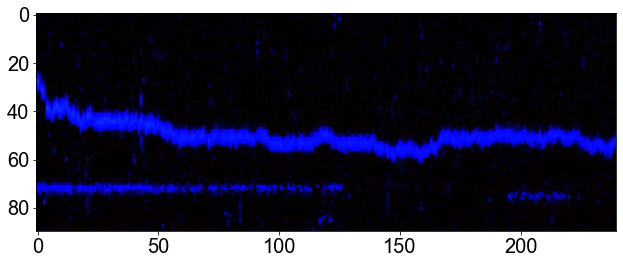

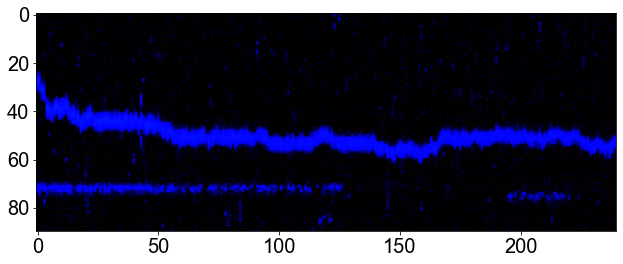

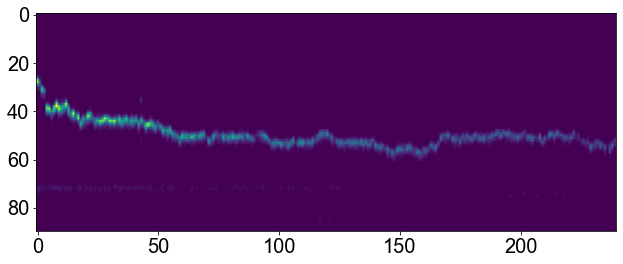

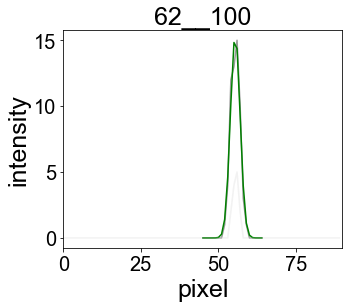

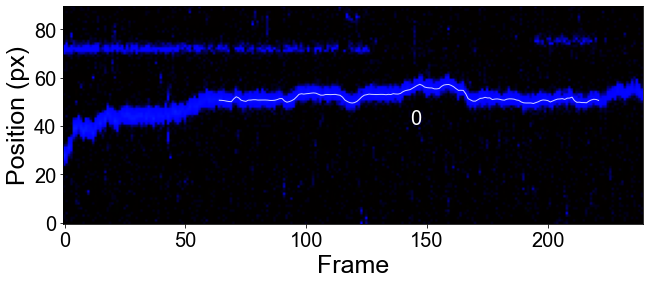

In [29]:
## Raw image, may have only increased intensity for the visual purposes
fig, ax = plt.subplots(figsize=(28, 4))   
plt.imshow(processed_image[crop_top:crop_bottom,crop_left:crop_right,:])
## Processed image, for the peak detection
fig, ax = plt.subplots(figsize=(28, 4))   
plt.imshow(processed_image2)


image_raw = np.int32(image_rgb_select[:,:,2])       ## Raw image, may have only increased intensity for the visual purposes
image_track = np.int32(processed_image2[:,:,2])     ## Processed image, for the peak detection

# Shapes must agree here, keep that in mind in case the image is "squeezed"
print(image_raw.shape)
print(image_track.shape)

################################# 
# DEFINE PARAMETERS FOR THE TRACKER

thres  = 0.01            ##  minimal relative intensity to be recognized by the peak finder function
jump = 10               ##  how many pixels maximally can a single molecule move within 1 time-frame
length = 100             ##  eliminate short trajectories which are probably noise
Gaussian_window = 10   ##  how many points around the peak should be the fitting done (reduce when there are many sliding molecules near each other)


(frames, found_ridges) = track_kymo(image_raw, image_track, thres, jump, length, Gaussian_window)

# OPTIONALLY: don't refer to the original image in case you sum neighboring frames (SQUEEZE) as then the image dimensions are different
#(frames, found_ridges) = track_kymo(image_track, image_track, thres, jump, length, Gaussian_window)


## Analyse individual traces


## Trace 0

In [30]:
trace = 0
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


FileExistsError: [Errno 17] File exists: 'Single-particle tracking/Trace0'

0.9964788732394366
Line time = 0.9964788732394366 second per 1 vertical line


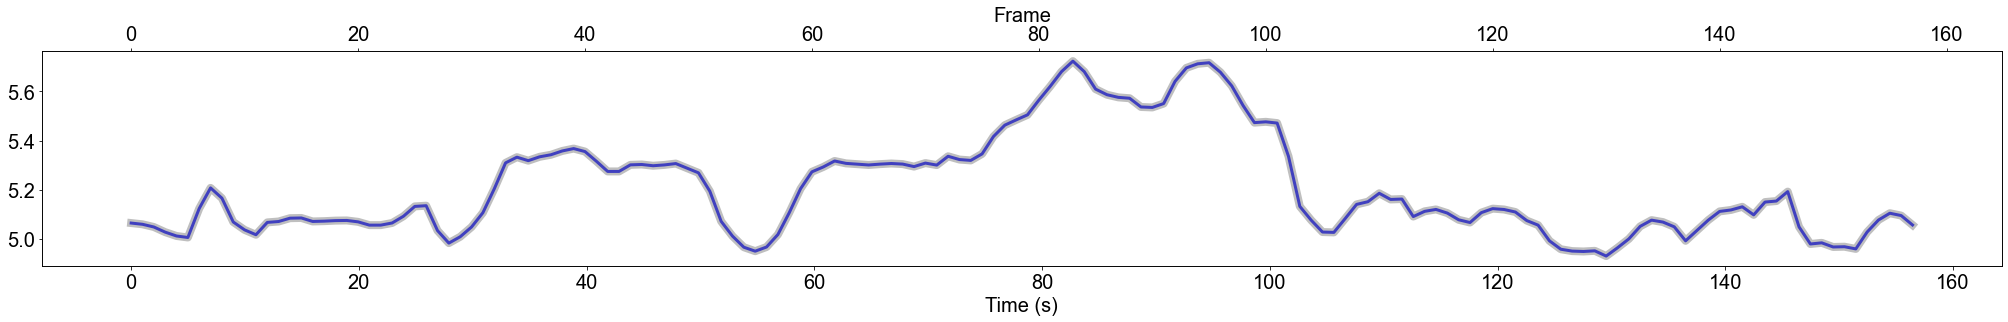

In [31]:
# Select trace

g = []

g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule

#
#trace = 0
#g0 = np.array(found_ridges[trace])

#trace = 1
#g1 = np.array(found_ridges[trace])
#g = np.concatenate((g0,g1))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
line_time = kymo_time/loaded_img.shape[1]
print(line_time)
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
#pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax1 = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(secs,(pos),'b',linewidth =3) 

ax2 = ax1.twiny()
ax2.plot(pos,'grey',linewidth =8,alpha=0.5) 


#ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()


#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax1.set_xlabel("Time (s)", fontsize=20)
ax2.set_xlabel("Frame", fontsize=20)


ax.set_ylabel("Position (μm)", fontsize=20)
#ax2=ax.twinx()
#ax2.plot(secs,pos_genomic,color="blue")
#ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos], delimiter=",")    # exports the peak position
#np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position


#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')


## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.9964788732394366


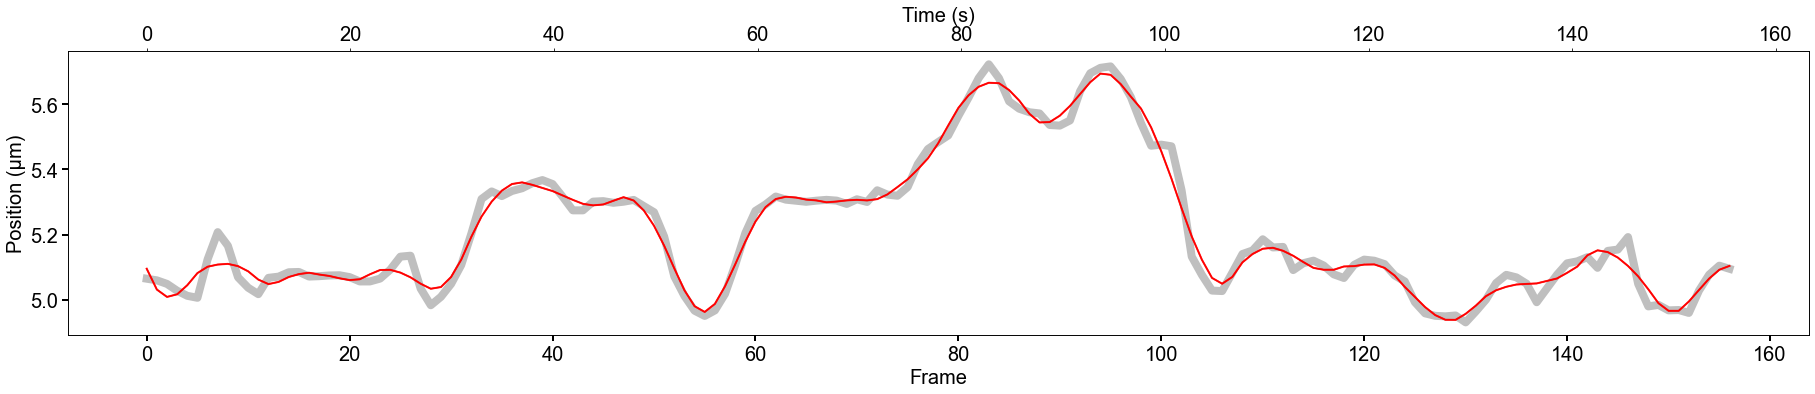

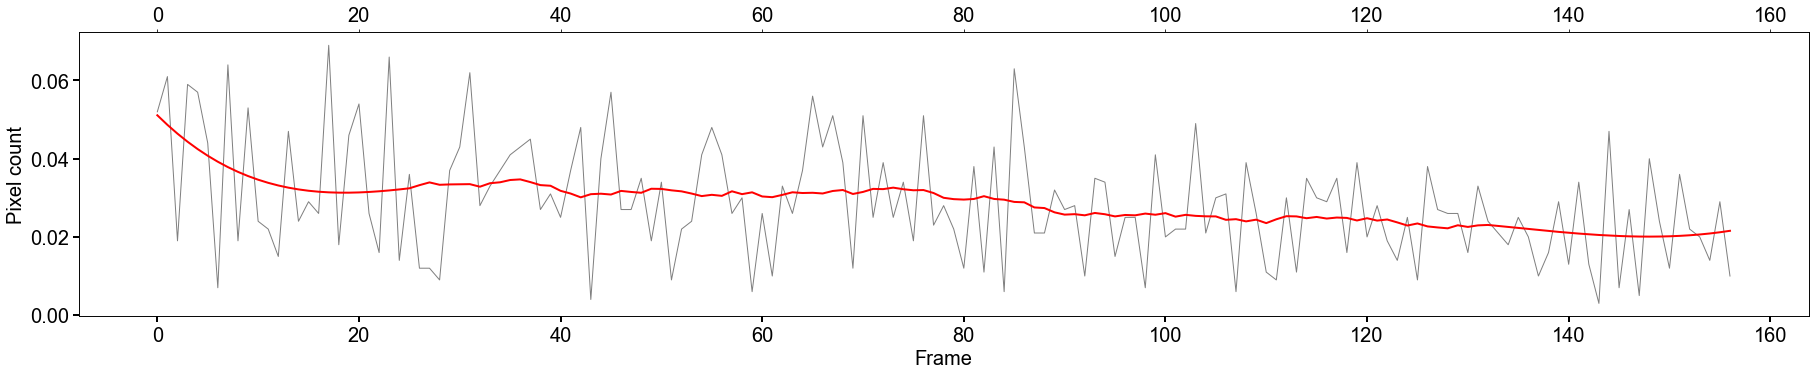

In [32]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 0
chop_back = -1
## Look at frames, crop edges if necessary, filter the data 
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

#pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =8,alpha=0.5) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'r',linewidth =2,alpha=0.8) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()


ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position



###### INTENSITIES FROM THE TRAJECTORY


# convert lists to arrays
xcor = frames[trace]
xcor_int = np.array([None]*len(xcor))

ycor = np.array(found_ridges[trace])
ycor_int = np.array([None]*len(ycor))

zcor_int = []

# convert to integers and find the corresponding intensity (0 - red, 1 - green, 2 - blue)
for i in range(len(xcor)):
    xcor_int[i] = int(xcor[i])
    ycor_int[i] = int(ycor[i])
    zcor_int = np.append(zcor_int,[processed_image2[ycor_int[i],xcor_int[i],1]],axis=0)

    


fig, ax1 = plt.subplots(figsize=(25, 5))
#plt.plot()

from scipy.signal import savgol_filter

SavGolwindow = 51
zcor_smooth = savgol_filter(zcor_int,SavGolwindow, 3)
#plt.plot(xcor_int,zcor_smooth,linewidth = 4, color='red')


ax1.plot(zcor_int[chop_front:chop_back],'gray',linewidth =1) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(zcor_smooth[chop_front:chop_back], color='red',linewidth=2)
fig.tight_layout()



#ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax1.set_ylabel("Pixel count", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'Intensitity' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Intensitiy' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[xcor_int,zcor_int], delimiter=",")    # exports the peak position






## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

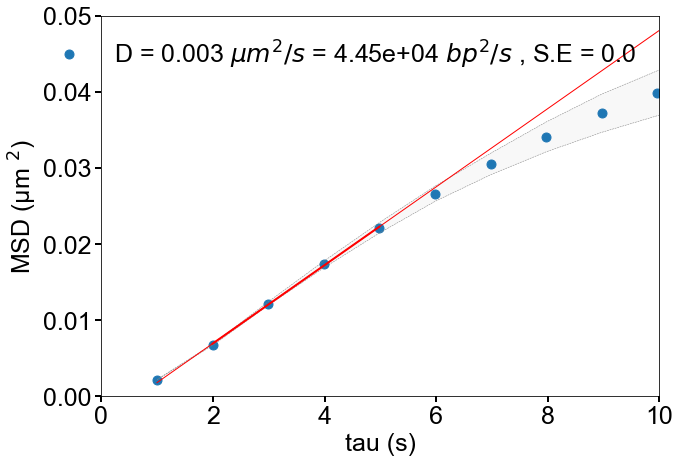

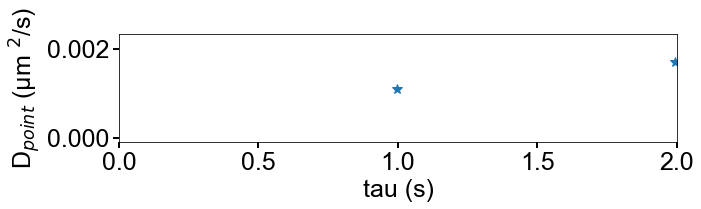

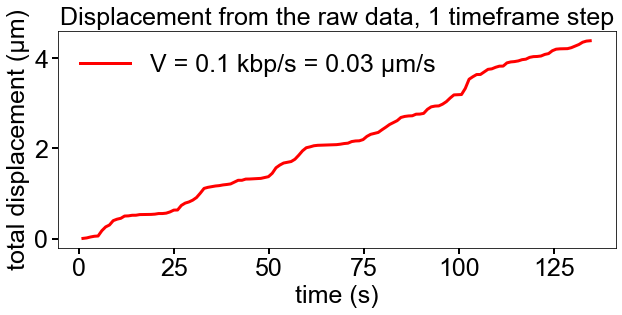

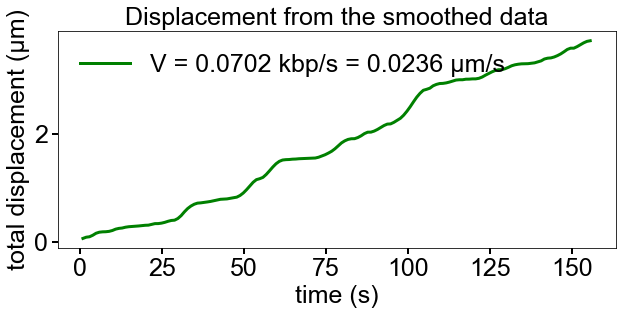

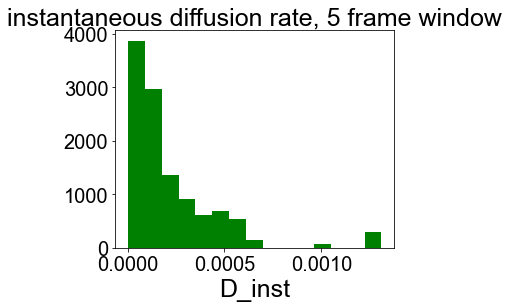

In [36]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 1
window_max = 5

param,cov = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1,cov=True)
#y = p*tau[window_min:window_max] + q
y = param[0]*tau + param[1]

#Standard error of the linear regression
covMSD = (np.sqrt(np.diag(cov)))

bp_um = param[0]*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 10])
ax.set_ylim([0, 0.05])
ax.legend(['D = ' + str(np.around(param[0]/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$" + " , S.E = " + str(np.around(covMSD[0]/2,decimals =4))],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position


# to bp2/s by multiplying over 8650519 

## Frame-to-frame shift distribution

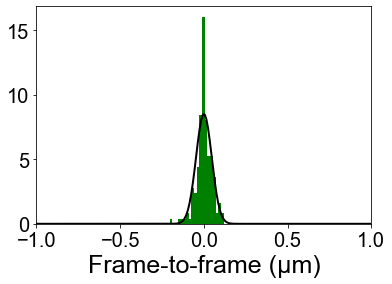

In [37]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()


Gaussian fit results: center = 0.00,  width = 0.05
Exponential fit results: center = 0.00,  var = 0.03


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


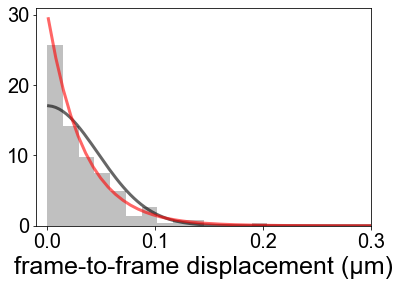

In [38]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')

plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_abs, delimiter=",")    # exports the peak position

plt.show()

# Trace 1


In [27]:
trace = 1
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


0.04924626012337817
Line time = 0.04924626012337817 second per 1 vertical line


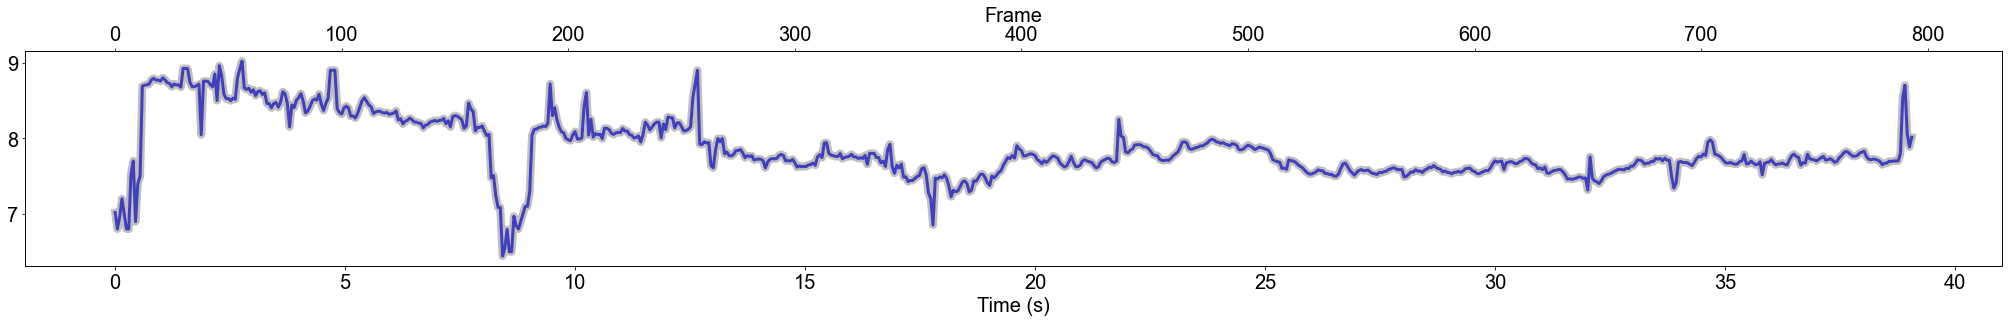

In [28]:
# Select trace

g = []

g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule

#
#trace = 0
#g0 = np.array(found_ridges[trace])

#trace = 1
#g1 = np.array(found_ridges[trace])
#g = np.concatenate((g0,g1))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
line_time = kymo_time/loaded_img.shape[1]
print(line_time)
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
#pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax1 = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(secs,(pos),'b',linewidth =3) 

ax2 = ax1.twiny()
ax2.plot(pos,'grey',linewidth =8,alpha=0.5) 


#ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()


#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax1.set_xlabel("Time (s)", fontsize=20)
ax2.set_xlabel("Frame", fontsize=20)


ax.set_ylabel("Position (μm)", fontsize=20)
#ax2=ax.twinx()
#ax2.plot(secs,pos_genomic,color="blue")
#ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos], delimiter=",")    # exports the peak position
#np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position


#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')


## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.04924626012337817


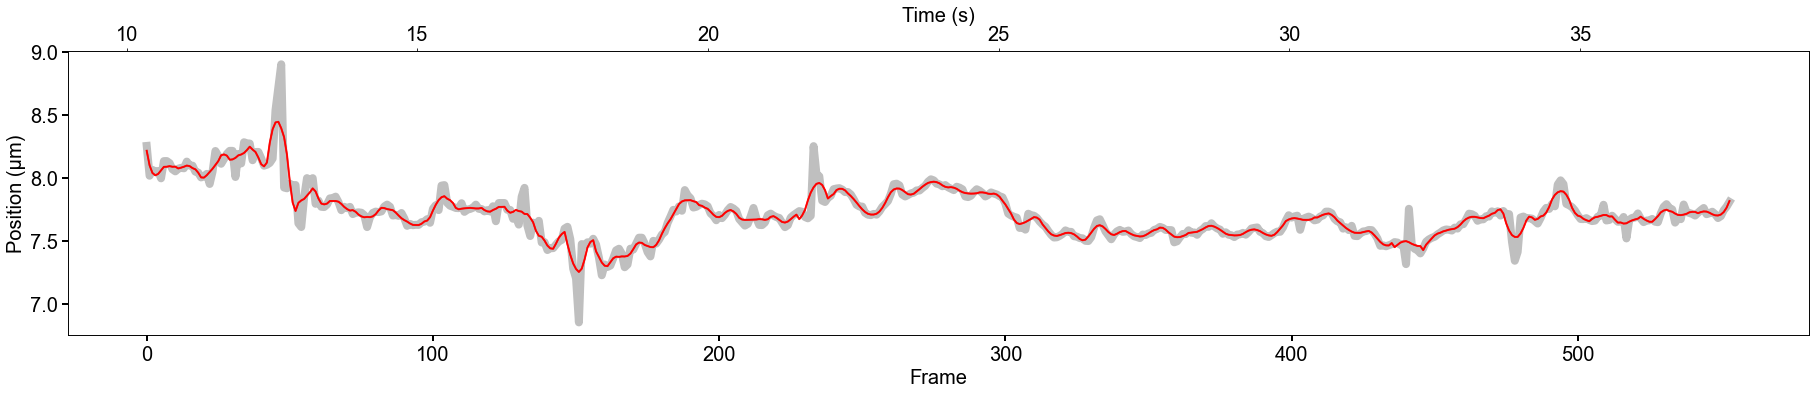

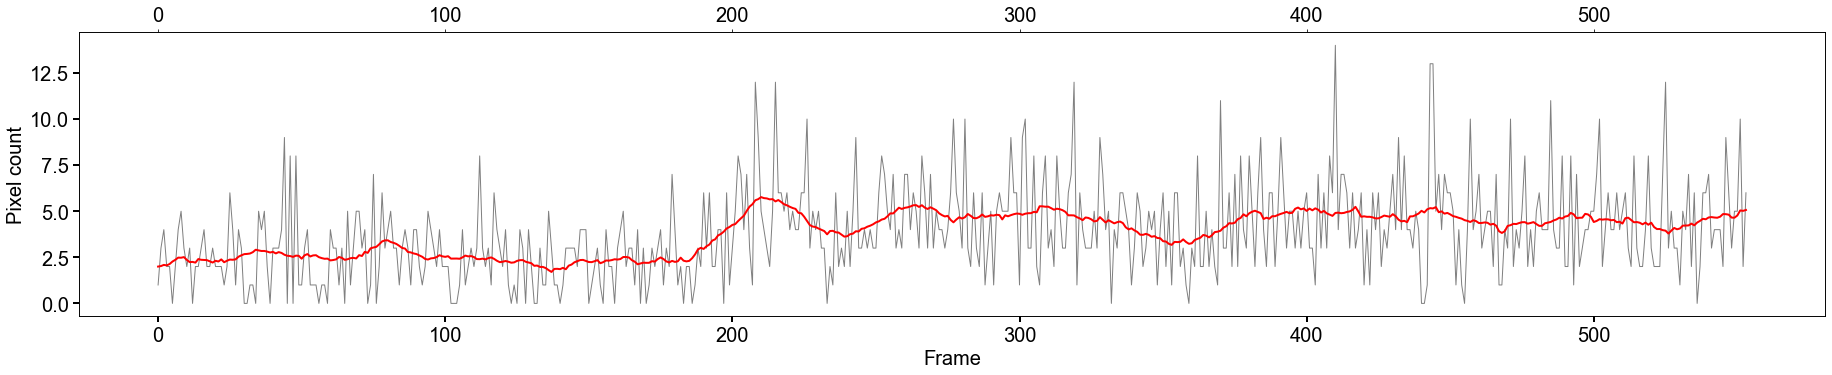

In [29]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 210
chop_back = -30
## Look at frames, crop edges if necessary, filter the data 
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

#pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =8,alpha=0.5) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'r',linewidth =2,alpha=0.8) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position



###### INTENSITIES FROM THE TRAJECTORY


# convert lists to arrays
xcor = frames[trace]
xcor_int = np.array([None]*len(xcor))

ycor = np.array(found_ridges[trace])
ycor_int = np.array([None]*len(ycor))

zcor_int = []

# convert to integers and find the corresponding intensity (0 - red, 1 - green, 2 - blue)
for i in range(len(xcor)):
    xcor_int[i] = int(xcor[i])
    ycor_int[i] = int(ycor[i])
    zcor_int = np.append(zcor_int,[processed_image2[ycor_int[i],xcor_int[i],1]],axis=0)

    


fig, ax1 = plt.subplots(figsize=(25, 5))
#plt.plot()

from scipy.signal import savgol_filter

SavGolwindow = 51
zcor_smooth = savgol_filter(zcor_int,SavGolwindow, 3)
#plt.plot(xcor_int,zcor_smooth,linewidth = 4, color='red')


ax1.plot(zcor_int[chop_front:chop_back],'gray',linewidth =1) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(zcor_smooth[chop_front:chop_back], color='red',linewidth=2)
fig.tight_layout()



#ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax1.set_ylabel("Pixel count", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'Intensitity' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Intensitiy' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[xcor_int,zcor_int], delimiter=",")    # exports the peak position




## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

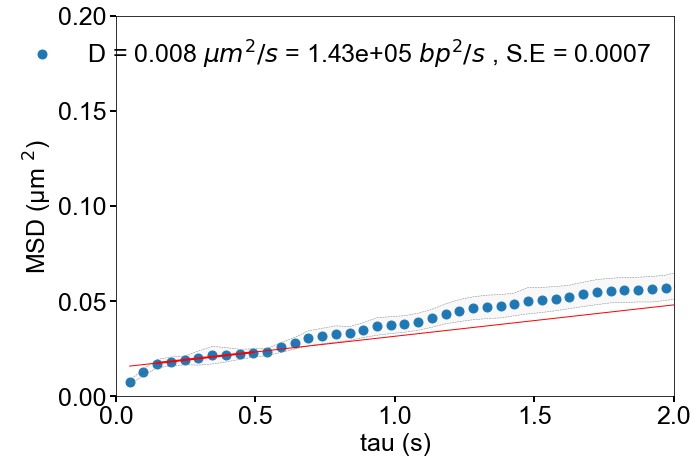

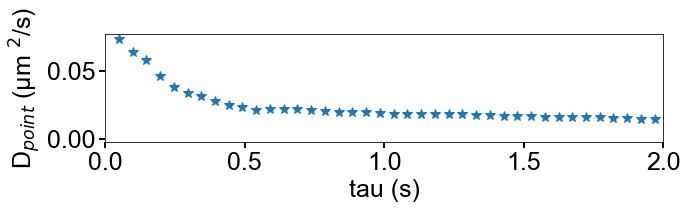

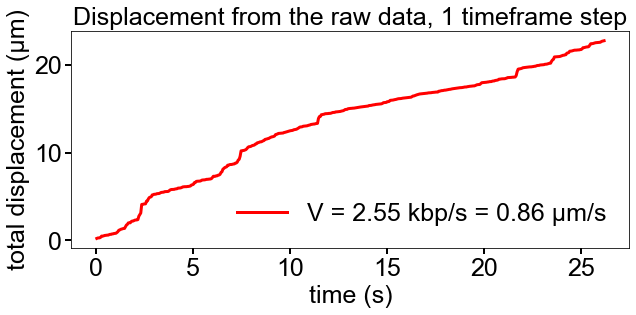

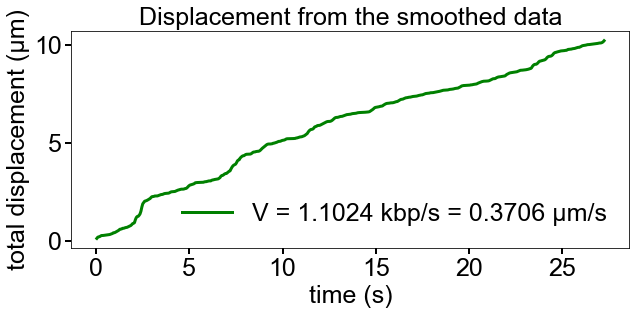

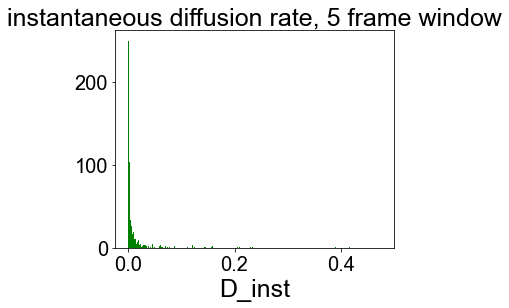

In [30]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 2
window_max = 10

param,cov = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1,cov=True)
#y = p*tau[window_min:window_max] + q
y = param[0]*tau + param[1]

#Standard error of the linear regression
covMSD = (np.sqrt(np.diag(cov)))

bp_um = param[0]*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 2])
ax.set_ylim([0, 0.2])
ax.legend(['D = ' + str(np.around(param[0]/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$" + " , S.E = " + str(np.around(covMSD[0]/2,decimals =4))],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position



## Single frame shift distribution

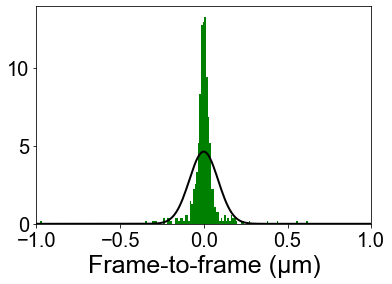

In [31]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()





Gaussian fit results: center = -0.00,  width = 0.09
Exponential fit results: center = 0.00,  var = 0.04


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


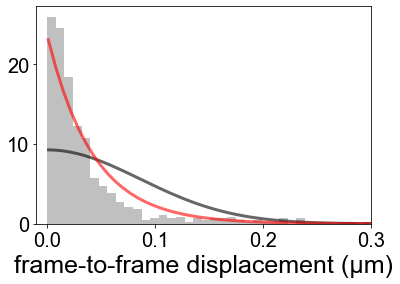

In [32]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')


plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_abs, delimiter=",")    # exports the peak position

plt.show()

## Trace 4


In [33]:
trace = 4
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


0.04924626012337817
Line time = 0.04924626012337817 second per 1 vertical line


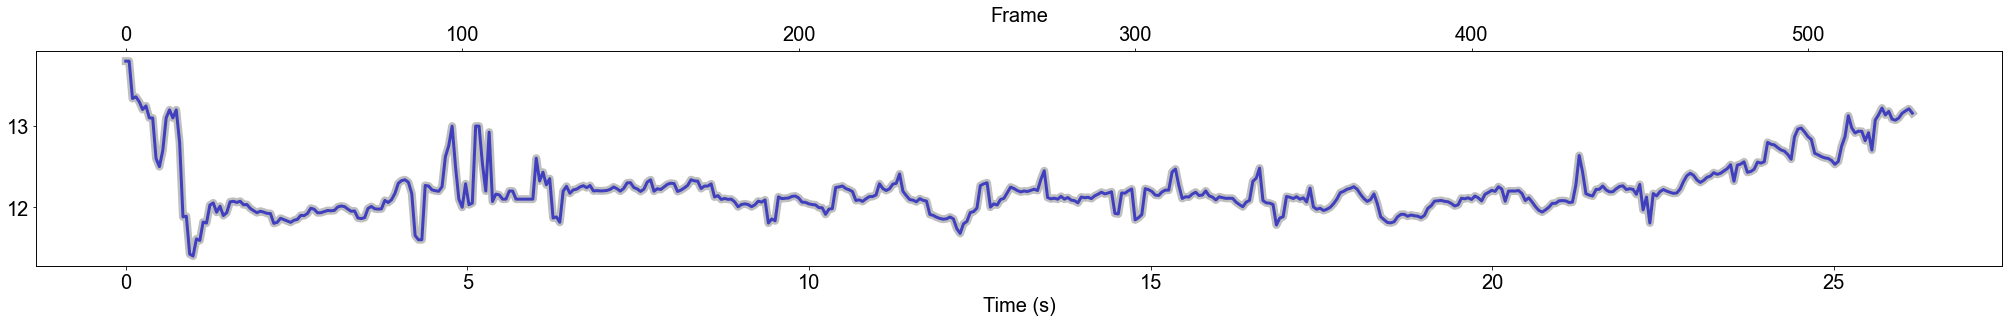

In [34]:
# Select trace

g = []

g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule

#
#trace = 0
#g0 = np.array(found_ridges[trace])

#trace = 1
#g1 = np.array(found_ridges[trace])
#g = np.concatenate((g0,g1))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
line_time = kymo_time/loaded_img.shape[1]
print(line_time)
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
#pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax1 = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(secs,(pos),'b',linewidth =3) 

ax2 = ax1.twiny()
ax2.plot(pos,'grey',linewidth =8,alpha=0.5) 


#ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()


#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax1.set_xlabel("Time (s)", fontsize=20)
ax2.set_xlabel("Frame", fontsize=20)


ax.set_ylabel("Position (μm)", fontsize=20)
#ax2=ax.twinx()
#ax2.plot(secs,pos_genomic,color="blue")
#ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos], delimiter=",")    # exports the peak position
#np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position


#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')



## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.04924626012337817


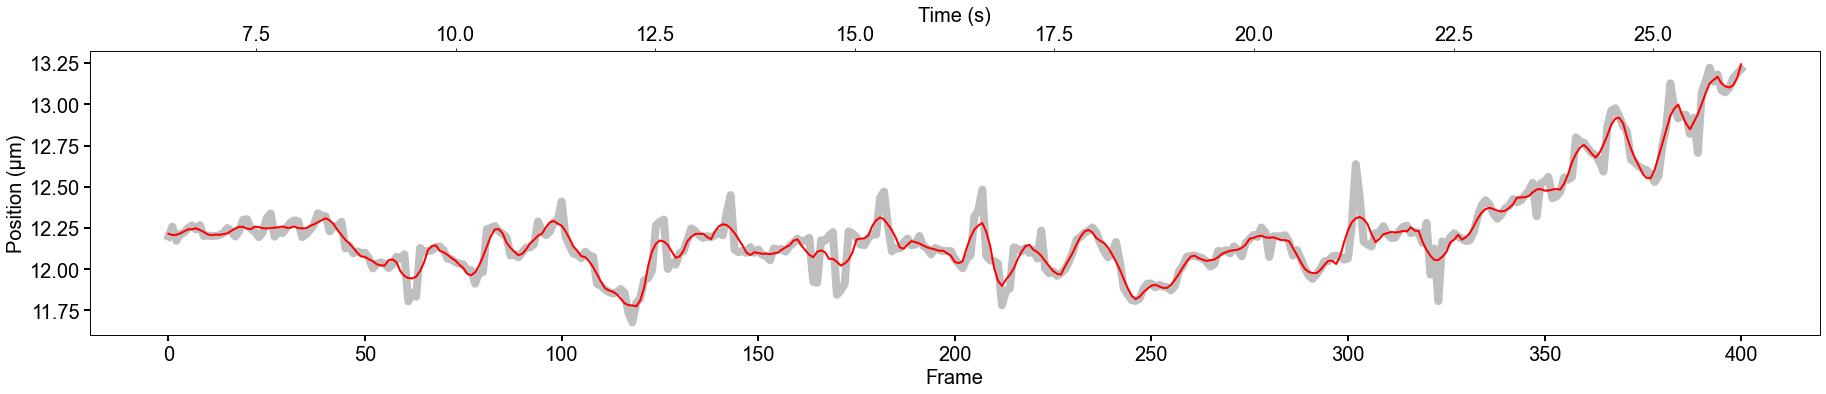

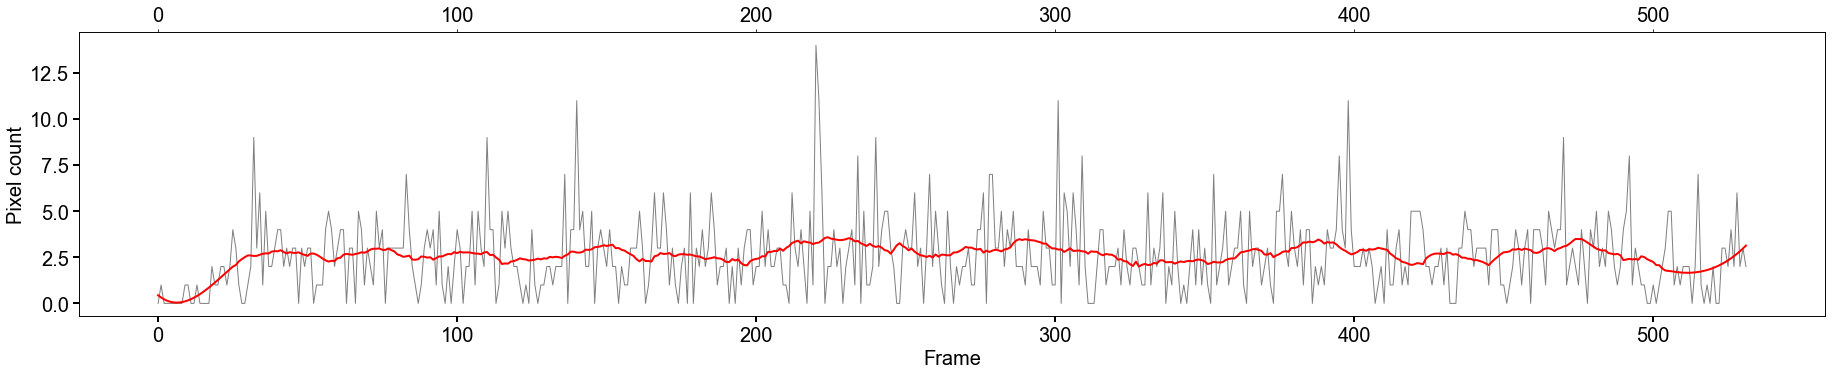

In [35]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 130
chop_back = -1
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

#pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =8,alpha=0.5) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'r',linewidth =2,alpha=0.8) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position



###### INTENSITIES FROM THE TRAJECTORY


# convert lists to arrays
xcor = frames[trace]
xcor_int = np.array([None]*len(xcor))

ycor = np.array(found_ridges[trace])
ycor_int = np.array([None]*len(ycor))

zcor_int = []

# convert to integers and find the corresponding intensity (0 - red, 1 - green, 2 - blue)
for i in range(len(xcor)):
    xcor_int[i] = int(xcor[i])
    ycor_int[i] = int(ycor[i])
    zcor_int = np.append(zcor_int,[processed_image2[ycor_int[i],xcor_int[i],1]],axis=0)

    


fig, ax1 = plt.subplots(figsize=(25, 5))
#plt.plot()

from scipy.signal import savgol_filter

SavGolwindow = 51
zcor_smooth = savgol_filter(zcor_int,SavGolwindow, 3)
#plt.plot(xcor_int,zcor_smooth,linewidth = 4, color='red')


ax1.plot(zcor_int,'gray',linewidth =1) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(zcor_smooth, color='red',linewidth=2)
fig.tight_layout()



#ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax1.set_ylabel("Pixel count", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'Intensitity' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Intensitiy' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[xcor_int,zcor_int], delimiter=",")    # exports the peak position








## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

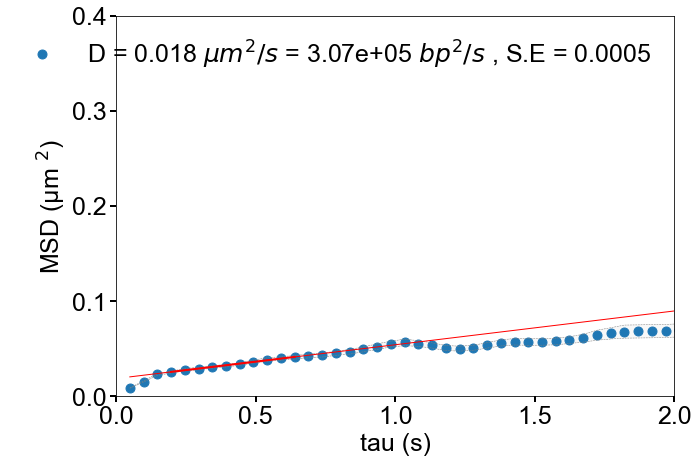

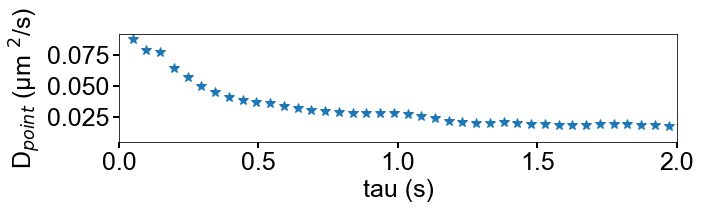

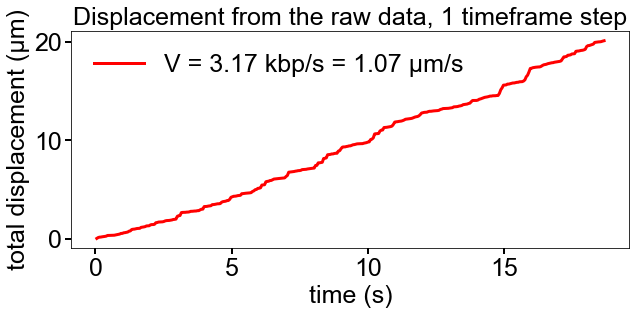

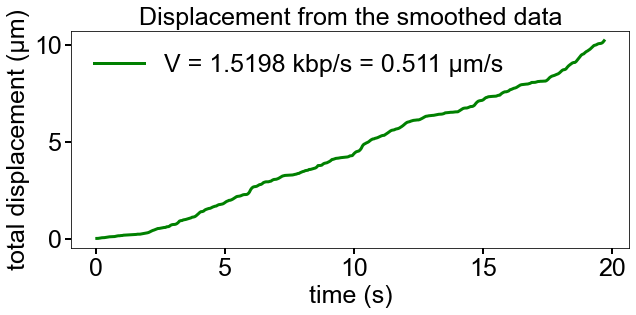

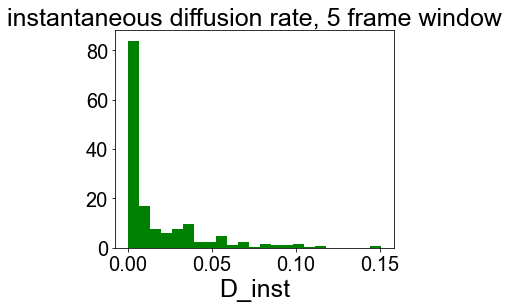

In [36]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 3
window_max = 13

param,cov = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1,cov=True)
#y = p*tau[window_min:window_max] + q
y = param[0]*tau + param[1]

#Standard error of the linear regression
covMSD = (np.sqrt(np.diag(cov)))

bp_um = param[0]*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 2])
ax.set_ylim([0, 0.4])
ax.legend(['D = ' + str(np.around(param[0]/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$" + " , S.E = " + str(np.around(covMSD[0]/2,decimals =4))],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position



## Single frame shift distribution

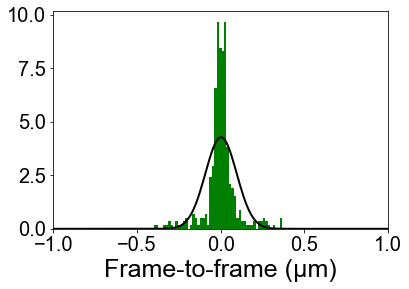

In [37]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()





## half PDF

In [ ]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')


plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_abs, delimiter=",")    # exports the peak position

plt.show()

## Trace 3

In [38]:
trace = 3
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


0.0666387859828245
Line time = 0.0666387859828245 second per 1 vertical line


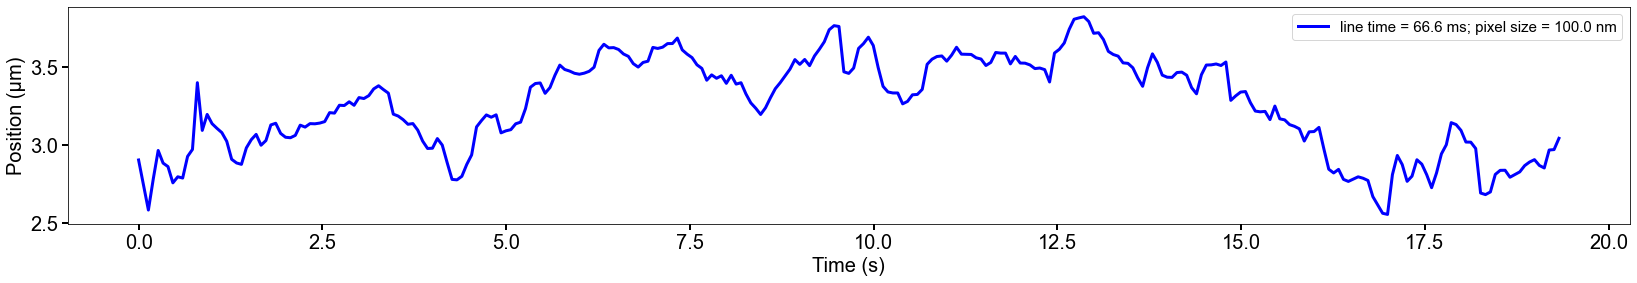

In [39]:
# Select trace

g = []

g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule

#
#trace = 0
#g0 = np.array(found_ridges[trace])

#trace = 1
#g1 = np.array(found_ridges[trace])
#g = np.concatenate((g0,g1))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
line_time = kymo_time/loaded_img.shape[1]
print(line_time)
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
#pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax.plot(secs,(pos),'b',linewidth =3) 

#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax.set_xlabel("Time (s)", fontsize=20)
ax.set_ylabel("Position (μm)", fontsize=20)
#ax2=ax.twinx()
#ax2.plot(secs,pos_genomic,color="blue")
#ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos], delimiter=",")    # exports the peak position
#np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position


#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')


## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.0666387859828245


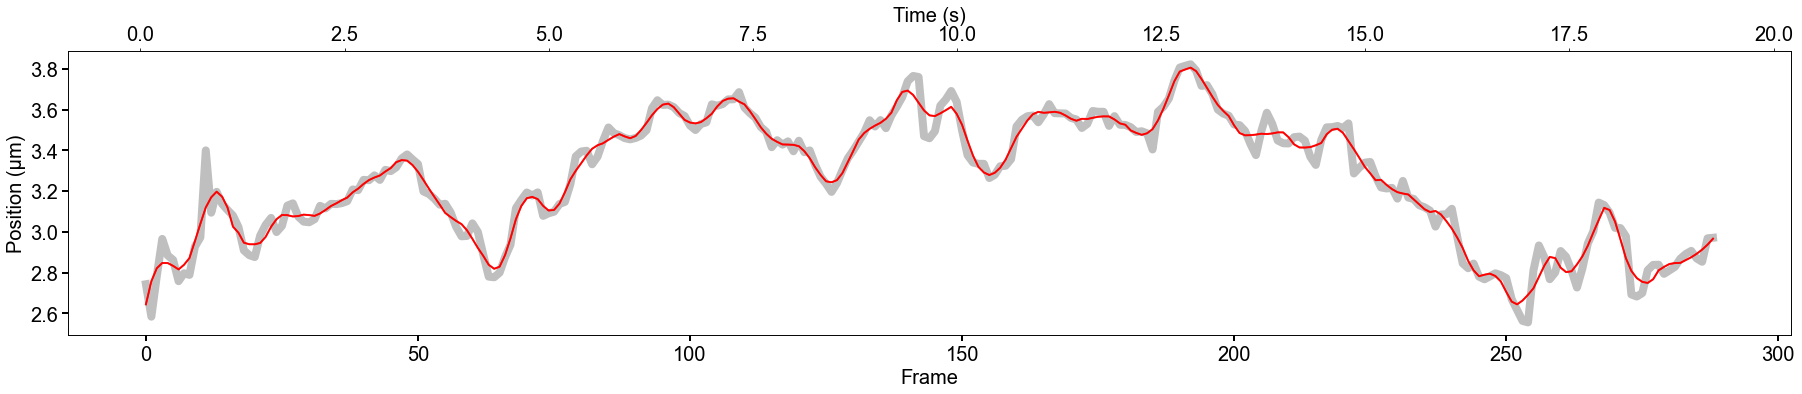

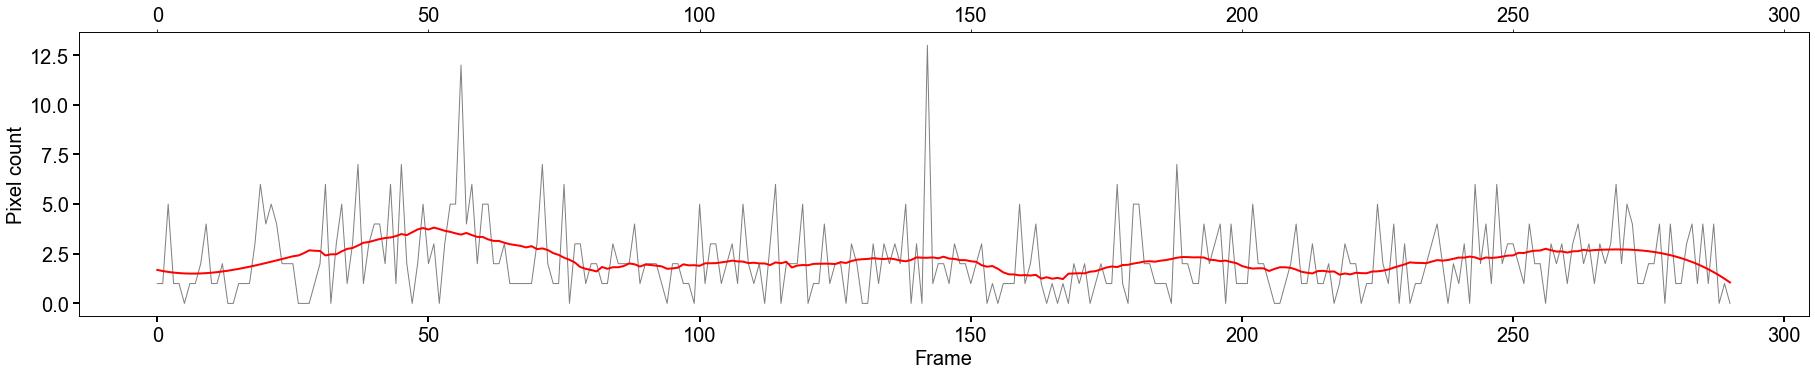

In [40]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 1
chop_back = -1
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

#pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =8,alpha=0.5) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'r',linewidth =2,alpha=0.8) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position



###### INTENSITIES FROM THE TRAJECTORY


# convert lists to arrays
xcor = frames[trace]
xcor_int = np.array([None]*len(xcor))

ycor = np.array(found_ridges[trace])
ycor_int = np.array([None]*len(ycor))

zcor_int = []

# convert to integers and find the corresponding intensity (0 - red, 1 - green, 2 - blue)
for i in range(len(xcor)):
    xcor_int[i] = int(xcor[i])
    ycor_int[i] = int(ycor[i])
    zcor_int = np.append(zcor_int,[processed_image2[ycor_int[i],xcor_int[i],1]],axis=0)

    


fig, ax1 = plt.subplots(figsize=(25, 5))
#plt.plot()

from scipy.signal import savgol_filter

SavGolwindow = 51
zcor_smooth = savgol_filter(zcor_int,SavGolwindow, 3)
#plt.plot(xcor_int,zcor_smooth,linewidth = 4, color='red')


ax1.plot(zcor_int,'gray',linewidth =1) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(zcor_smooth, color='red',linewidth=2)
fig.tight_layout()



#ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax1.set_ylabel("Pixel count", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'Intensitity' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Intensitiy' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[xcor_int,zcor_int], delimiter=",")    # exports the peak position





## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

<ipython-input-42-53e833550140>:104: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(1,np.int(np.round((N-20)/avg_window))-1):


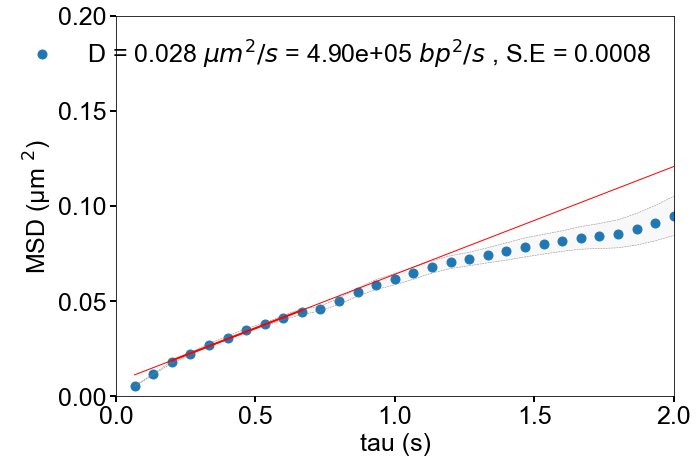

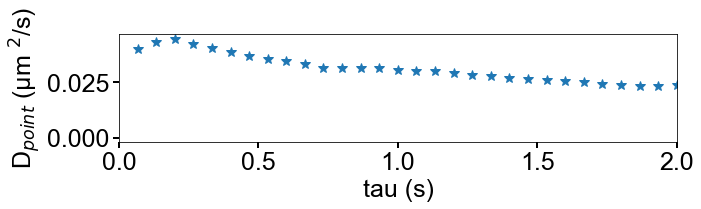

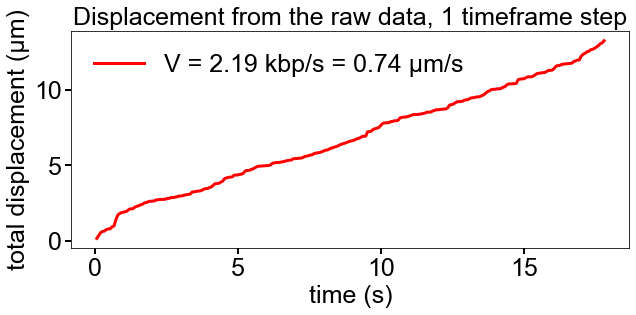

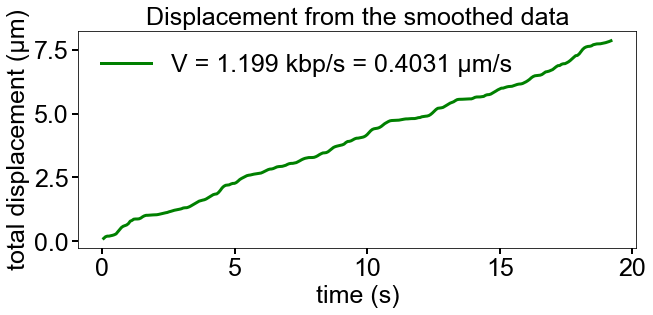

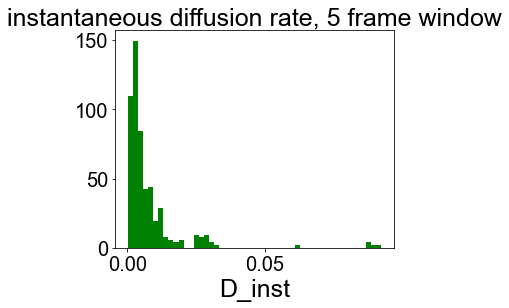

In [42]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 2
window_max = 10

param,cov = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1,cov=True)
#y = p*tau[window_min:window_max] + q
y = param[0]*tau + param[1]

#Standard error of the linear regression
covMSD = (np.sqrt(np.diag(cov)))

bp_um = param[0]*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 2])
ax.set_ylim([0, 0.2])
ax.legend(['D = ' + str(np.around(param[0]/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$" + " , S.E = " + str(np.around(covMSD[0]/2,decimals =4))],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,np.int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position




## Frame-to-frame shift distribution

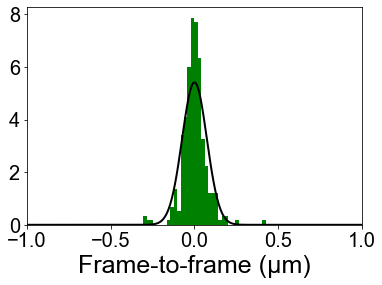

In [43]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()


Gaussian fit results: center = 0.00,  width = 0.07
Exponential fit results: center = 0.00,  var = 0.05


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


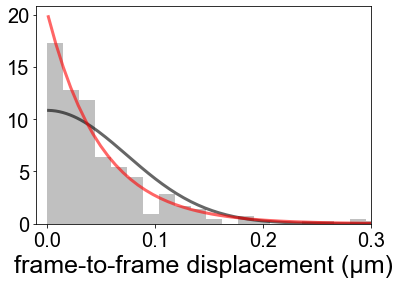

In [44]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')


plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position

plt.show()

## Trace 4

In [45]:
trace = 4
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


0.0666387859828245
Line time = 0.0666387859828245 second per 1 vertical line


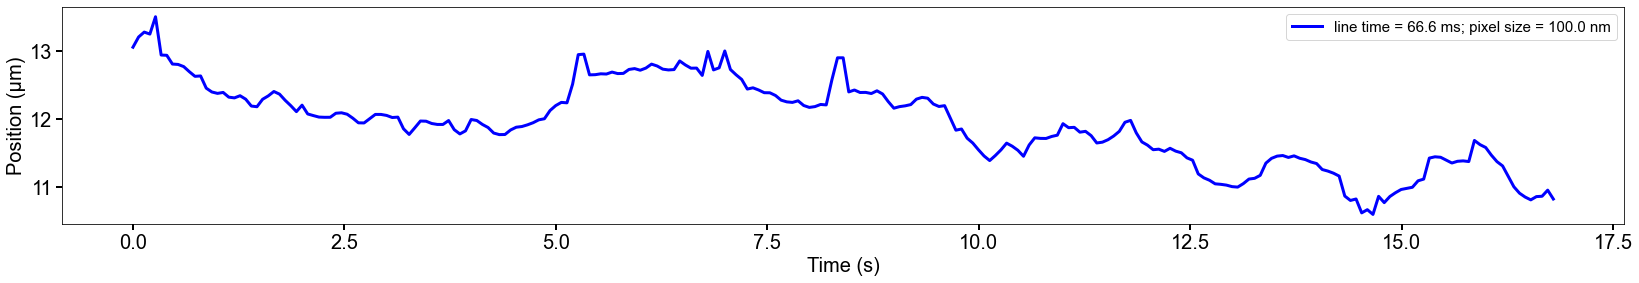

In [47]:
# Select trace

g = []

g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule

#
#trace = 0
#g0 = np.array(found_ridges[trace])

#trace = 1
#g1 = np.array(found_ridges[trace])
#g = np.concatenate((g0,g1))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
line_time = kymo_time/loaded_img.shape[1]
print(line_time)
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
#pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax.plot(secs,(pos),'b',linewidth =3) 

#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax.set_xlabel("Time (s)", fontsize=20)
ax.set_ylabel("Position (μm)", fontsize=20)
#ax2=ax.twinx()
#ax2.plot(secs,pos_genomic,color="blue")
#ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos], delimiter=",")    # exports the peak position
#np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position


#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')


## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.0666387859828245


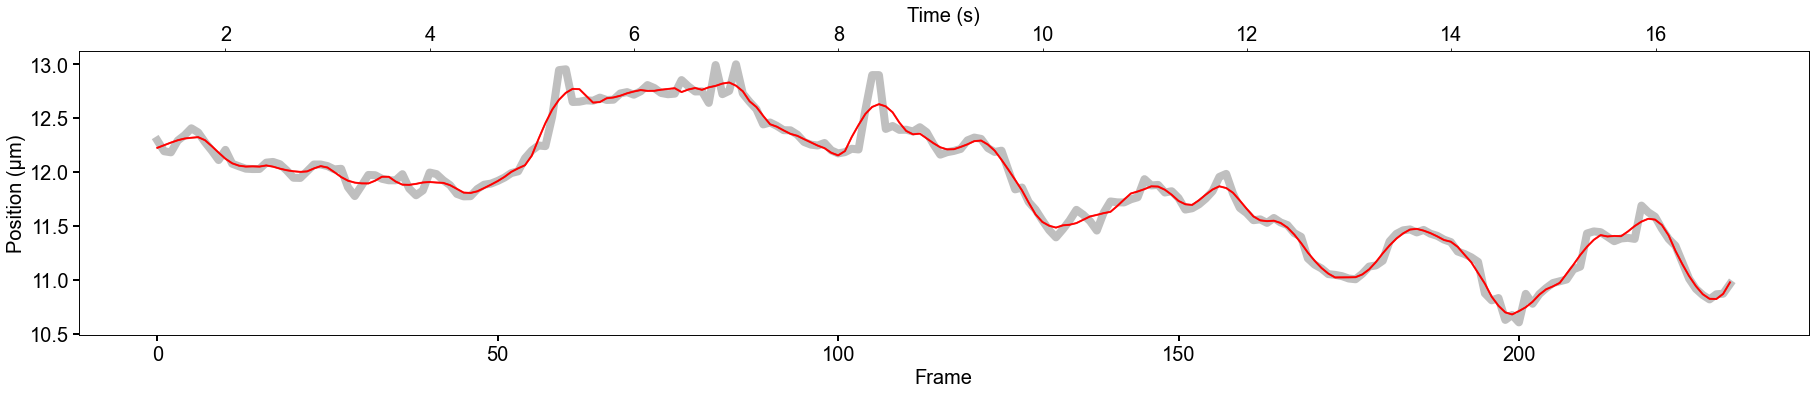

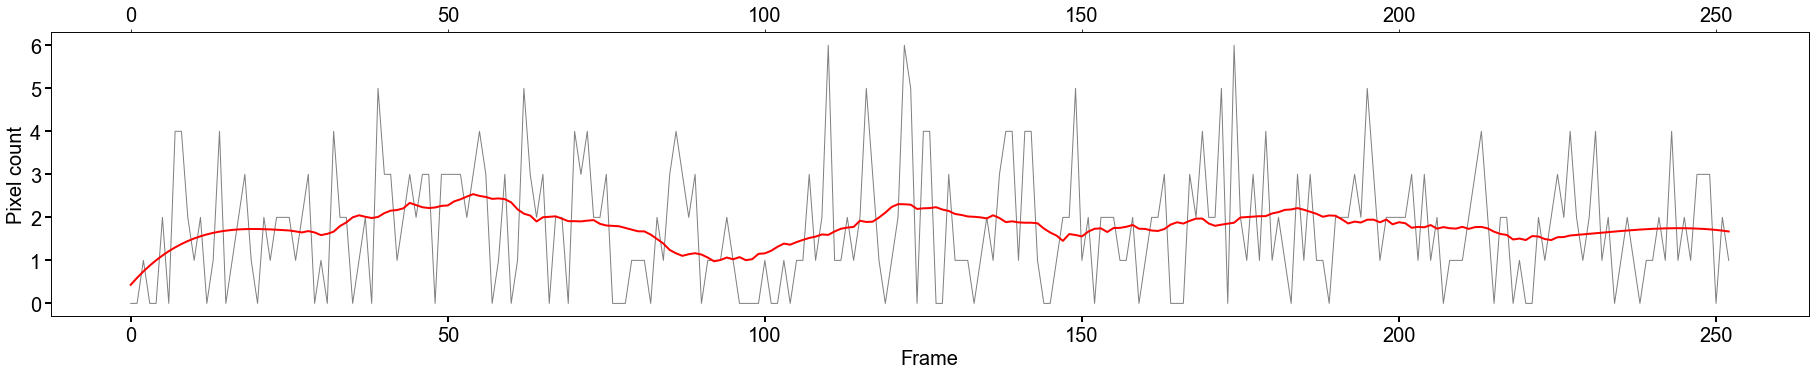

In [48]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 20
chop_back = -1
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

#pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =8,alpha=0.5) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'r',linewidth =2,alpha=0.8) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(secs[chop_front:chop_back],pos_smooth, color='red')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position



###### INTENSITIES FROM THE TRAJECTORY


# convert lists to arrays
xcor = frames[trace]
xcor_int = np.array([None]*len(xcor))

ycor = np.array(found_ridges[trace])
ycor_int = np.array([None]*len(ycor))

zcor_int = []

# convert to integers and find the corresponding intensity (0 - red, 1 - green, 2 - blue)
for i in range(len(xcor)):
    xcor_int[i] = int(xcor[i])
    ycor_int[i] = int(ycor[i])
    zcor_int = np.append(zcor_int,[processed_image2[ycor_int[i],xcor_int[i],1]],axis=0)

    


fig, ax1 = plt.subplots(figsize=(25, 5))
#plt.plot()

from scipy.signal import savgol_filter

SavGolwindow = 51
zcor_smooth = savgol_filter(zcor_int,SavGolwindow, 3)
#plt.plot(xcor_int,zcor_smooth,linewidth = 4, color='red')


ax1.plot(zcor_int,'gray',linewidth =1) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(zcor_smooth, color='red',linewidth=2)
fig.tight_layout()



#ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax1.set_ylabel("Pixel count", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'Intensitity' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Intensitiy' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[xcor_int,zcor_int], delimiter=",")    # exports the peak position





## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

<ipython-input-50-fafaa2f73ebd>:104: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(1,np.int(np.round((N-20)/avg_window))-1):


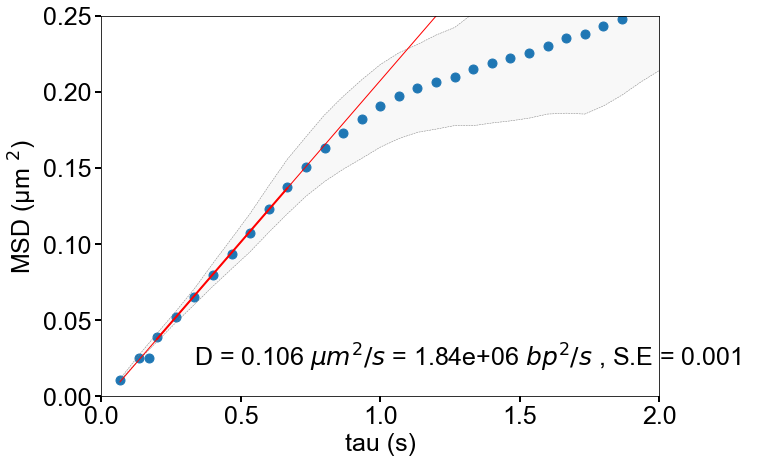

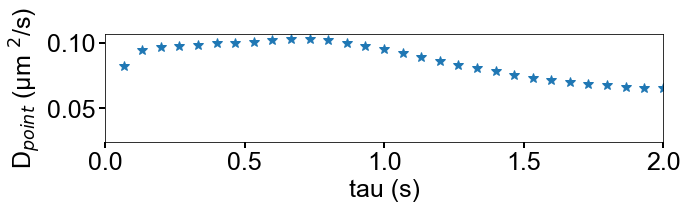

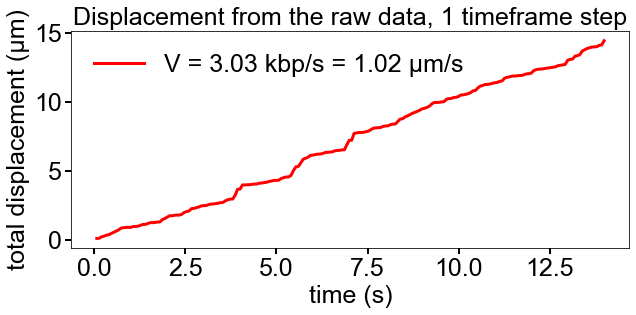

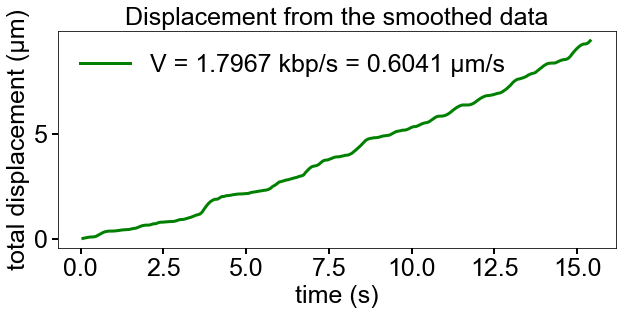

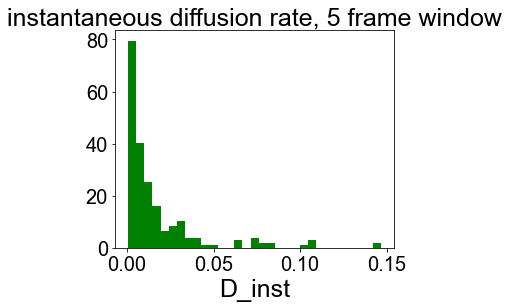

In [50]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 2
window_max = 10

param,cov = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1,cov=True)
#y = p*tau[window_min:window_max] + q
y = param[0]*tau + param[1]

#Standard error of the linear regression
covMSD = (np.sqrt(np.diag(cov)))

bp_um = param[0]*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 2])
ax.set_ylim([0, 0.25])
ax.legend(['D = ' + str(np.around(param[0]/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$" + " , S.E = " + str(np.around(covMSD[0]/2,decimals =4))],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,np.int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position




## Frame-to-frame shift distribution

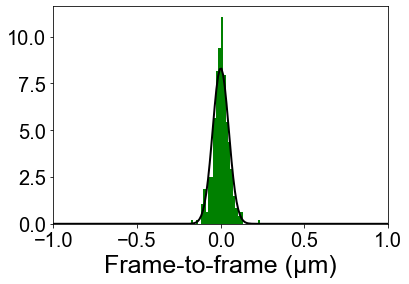

In [27]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()


Gaussian fit results: center = 0.00,  width = 0.05
Exponential fit results: center = 0.00,  var = 0.04


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


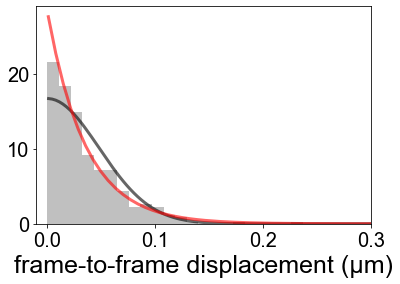

In [28]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')


plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position

plt.show()

In [47]:
trace = 4
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


In [48]:
# Select trace

g = []
g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule
#trace = 39
#g39 = np.array(found_ridges[trace])

#g = np.concat(g20,g22)
#g = np.concatenate((g12,g13))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
print(line_time)
line_time = kymo_time/loaded_img.shape[1]
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax.plot(secs,(pos),'b',linewidth =3) 

#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax.set_xlabel("Time (s)", fontsize=20)
ax.set_ylabel("Position (μm)", fontsize=20)
ax2=ax.twinx()
ax2.plot(secs,pos_genomic,color="blue")
ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position
#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')


0.06663809724850156
Line time = 0.06663809724850156 second per 1 vertical line


IndexError: index -120 is out of bounds for axis 0 with size 20

## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.06890311175909947


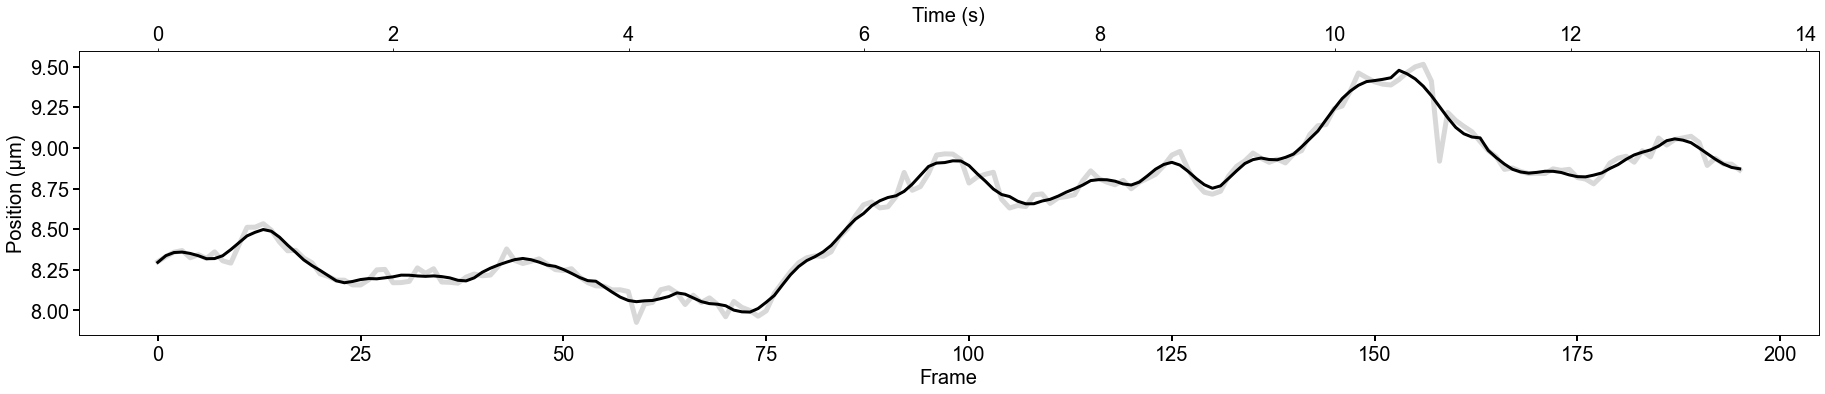

In [44]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 0   #the beginning contains two olecules co-sliding, so I exclude it
chop_back = -1
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =5,alpha=0.3) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'k',linewidth =3) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(secs[chop_front:chop_back],pos_smooth, color='black')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position





## Intensities in the trajectory

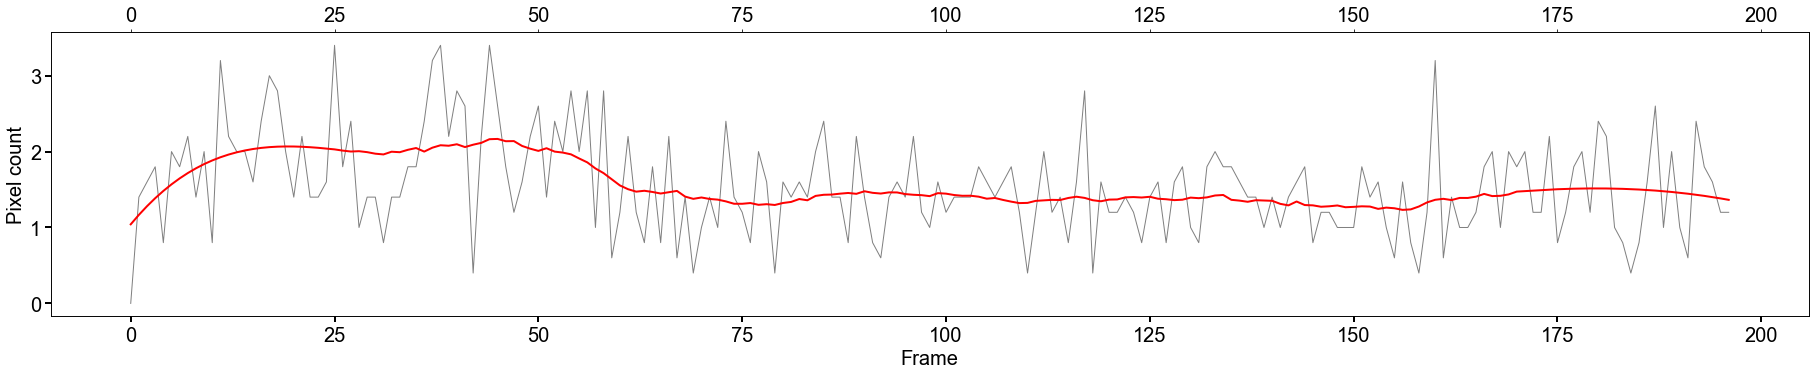

In [45]:
# convert lists to arrays
xcor = frames[trace]
xcor_int = np.array([None]*len(xcor))

ycor = np.array(found_ridges[trace])
ycor_int = np.array([None]*len(ycor))

zcor_int = []

# convert to integers and find the corresponding intensity (0 - red, 1 - green, 2 - blue)
for i in range(len(xcor)):
    xcor_int[i] = int(xcor[i])
    ycor_int[i] = int(ycor[i])
    zcor_int = np.append(zcor_int,[processed_image2[ycor_int[i],xcor_int[i],1]],axis=0)

    


fig, ax1 = plt.subplots(figsize=(25, 5))
#plt.plot()

from scipy.signal import savgol_filter
SavGolwindow = 51
zcor_smooth = savgol_filter(zcor_int,SavGolwindow, 3)
#plt.plot(xcor_int,zcor_smooth,linewidth = 4, color='red')


ax1.plot(zcor_int,'gray',linewidth =1) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(zcor_smooth, color='red',linewidth=2)
fig.tight_layout()



#ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax1.set_ylabel("Pixel count", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'Intensitity' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Intensitiy' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[xcor_int,zcor_int], delimiter=",")    # exports the peak position



## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

<ipython-input-47-a73c30c5518a>:102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(1,np.int(np.round((N-20)/avg_window))-1):


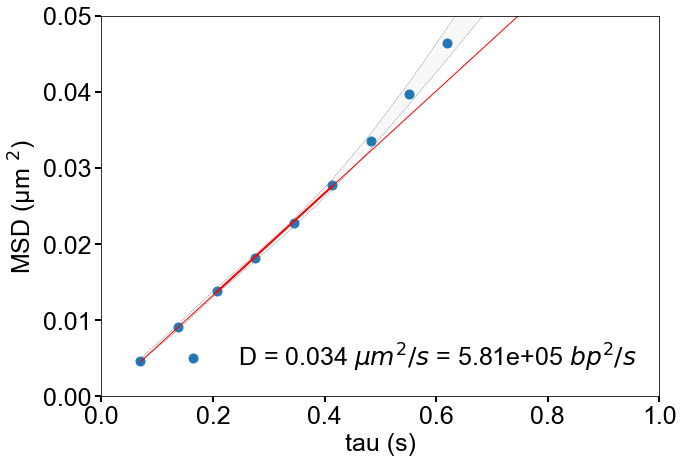

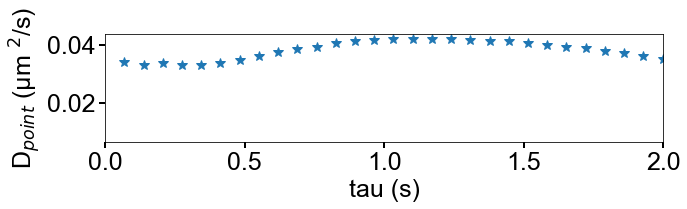

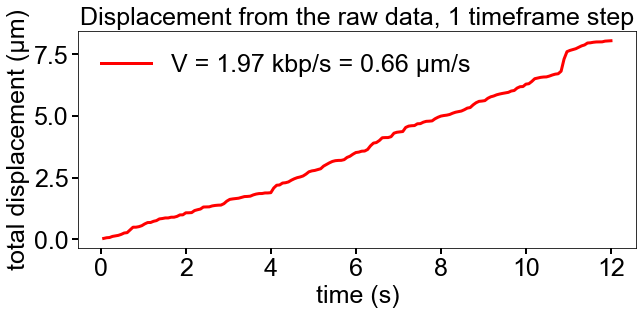

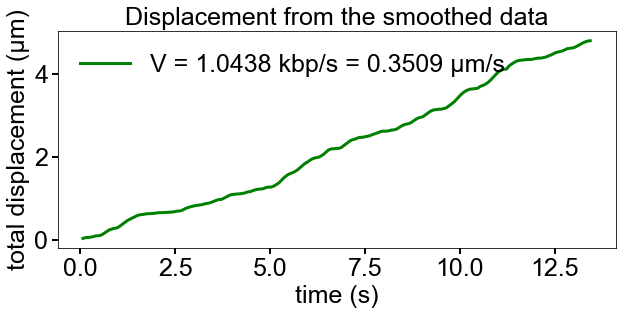

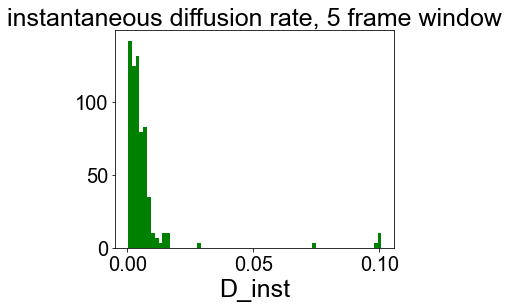

In [47]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 2
window_max = 6

p,q = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1)
#y = p*tau[window_min:window_max] + q
y = p*tau + q


bp_um = p*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.05])
ax.legend(['D = ' + str(np.around(p/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$"],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,np.int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position



## Single frame shift distribution

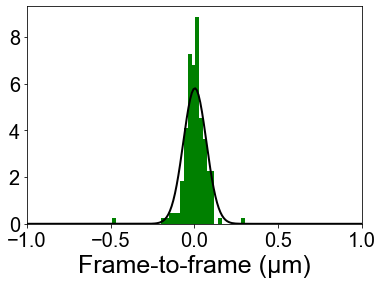

In [48]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()





Gaussian fit results: center = -0.00,  width = 0.07
Exponential fit results: center = 0.00,  var = 0.04


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


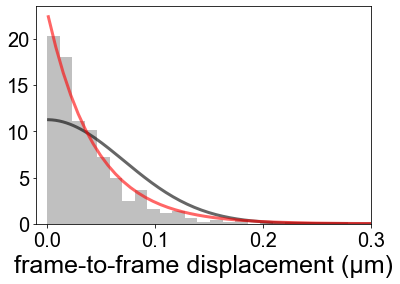

In [131]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')


plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position

plt.show()

## Trace 7


In [49]:
trace = 7
os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


0.06890311175909947
Line time = 0.06890311175909947 second per 1 vertical line


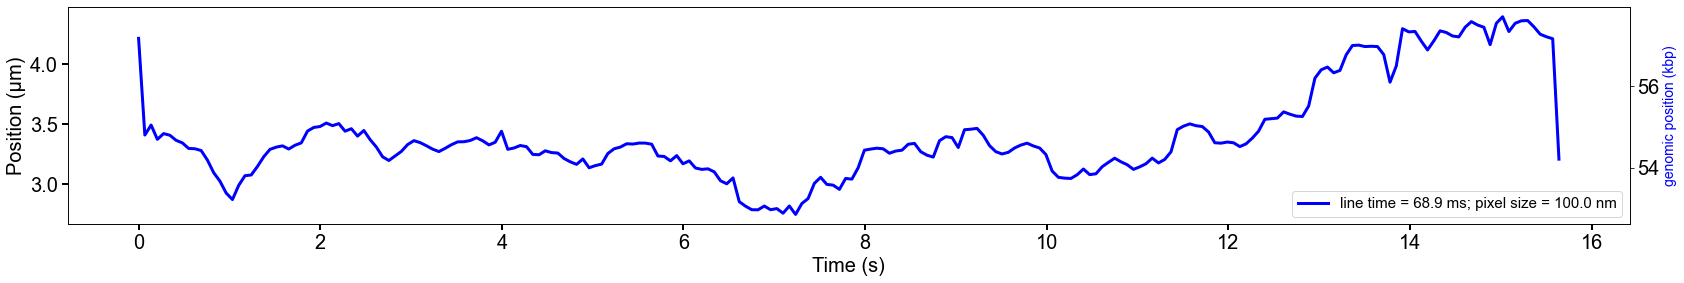

In [50]:
# Select trace

g = []
g = np.array(found_ridges[trace])

## Optionally,  merge a few trajectories together is thery belong to a one molecule
#trace = 39
#g39 = np.array(found_ridges[trace])

#g = np.concat(g20,g22)
#g = np.concatenate((g12,g13))
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))


### MAke sure the linetime is not messed up in case the image was squeezed earlier
print(line_time)
line_time = kymo_time/loaded_img.shape[1]
line_time = line_time * level_hsum # important when squeezing the image
print('Line time = '+str(line_time) +' second per 1 vertical line')
#os.makedirs('Single-particle tracking' +'/'+'Trace' + str(trace))



#t = np.array(frames[2])
#pos = np.around(g*(ps/1000),decimals =3)   # from pixel to micrometer knowing the pixel size
pos = g*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]
pos_genomic = pos*2.941 + position[crop_top - roi_left] 


# Top of the kymograph includes a half of the bead and 10 additional lines (offset) which needs to be excluded when calculating the genomic position
#start_img = ((10*ps+0.5*bs)/1000)  

# Vector of time (earlier, the code worked on frame numbers)
secs = []
for i in range(0,len(g)):
    secs = np.append(secs,line_time*i)
    

fig, ax = plt.subplots(figsize=(28, 4))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax.plot(secs,(pos),'b',linewidth =3) 

#plt.gca().invert_yaxis()
#show()
ax.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm'], fontsize=15)
ax.set_xlabel("Time (s)", fontsize=20)
ax.set_ylabel("Position (μm)", fontsize=20)
ax2=ax.twinx()
ax2.plot(secs,pos_genomic,color="blue")
ax2.set_ylabel("genomic position (kbp)",color="blue",fontsize=14)
#plt.show()
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '__'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '__'+  str(name[0:15]) +'.csv', np.c_[secs,pos,pos_genomic], delimiter=",")    # exports the peak position
#np.savetxt(str(name[0:15]) +' tracked_data_' + str(start) + 's_' + str(end) + 's_trace_'+ str(trace)+'s_Kymo '  + (kymo_number[index]) + '.csv', np.c_[secs,pos-start_img], delimiter=",")    # exports the peak position


#plt.savefig(str(name[0:15]) +' tracked_32bit_' + str(start) + 's_' + str(end) + 's_Kymo ' +(kymo_number[index]) + '.png', dpi=300, bbox_inches='tight')


## Calculate diffusion rate for the selected trace


1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

0.06890311175909947


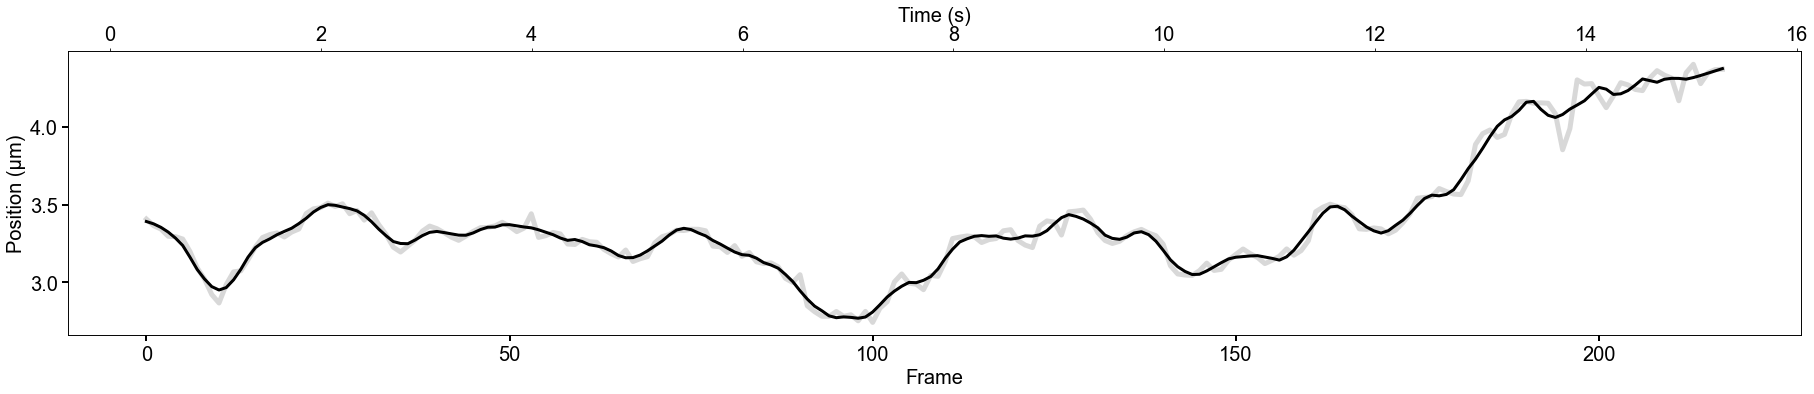

In [51]:
## Look at frames, crop edges if necessary, filter the data 

print(line_time)

chop_front = 5   #the beginning contains two olecules co-sliding, so I exclude it
chop_back = -5
pos = g[chop_front:chop_back]*(ps/1000)

## making use of the interpolation I did earlier 
## I take the genomic position from the point I started the cropping from (keeping in mind the interpolation done earlier was not done in a silly way - it excluded the first few peaks lower that roi_left
## (1 um = 2.941 kb)  [[I HATE THE WAY I DID IT BUT OK... THERE MIGHT BE A SMALL OFFSET]]

pos_genomic = pos * 2.941 + position[crop_top - roi_left] 

fig, ax1 = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos,'grey',linewidth =5,alpha=0.3) 


from scipy.signal import savgol_filter
pos_smooth = []
SavGolwindow = 11
pos_smooth = savgol_filter(pos,SavGolwindow, 3)

#fig, ax = plt.subplots(figsize=(25, 5))   # ploting the raw image, 1st derivative image and 2nd derivative image
#ax.plot(secs,(pos-start_img),'b',linewidth =3) 
ax1.plot(pos_smooth,'k',linewidth =3) 
ax1.tick_params(direction='out', length=6, width=2, labelsize= 20, grid_color='r', grid_alpha=0.5)
ax2 = ax1.twiny()

ax2.plot(secs[chop_front:chop_back],pos_smooth, color='black')
fig.tight_layout()



ax.legend(['line time = '+ str(round(line_time*1000,1))+' ms; pixel size = '+str(ps)+' nm','Savitzky-Golay filter window = ' +str(SavGolwindow)], fontsize=15)
ax1.set_xlabel("Frame", fontsize=20)
ax2.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Position (μm)", fontsize=20)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' + 'tracked_data_SGsmooth' +'_trace_'+str(trace) + '_Kymo ' + (kymo_number[index]) + '_'+str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'tracked_data_SGsmooth' + '_trace_'+ str(trace)+'_Kymo '  + (kymo_number[index]) + '_'+  str(name[0:15]) +'.csv', np.c_[secs[chop_front:chop_back],pos,pos_smooth], delimiter=",")    # exports the peak position





## Calculate diffusion coefficient 

1D diffusion coefficient (D) of each molecule is calculated from mean square displacement (MSD), which is given as:

### $ MSD (n,N) = \sum_{i=1}^{N-n} \frac{(Y_{i+n}-Y_{i})^2}{N-n} = 2Dn\Delta t   $ 

where N is the total number of time frames, n is the measurement window ranging from 1 to N-1, Δt is the time interval between frames (line time), and Y is the position of the molecule along DNA

<ipython-input-52-25d03ab907da>:102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(1,np.int(np.round((N-20)/avg_window))-1):


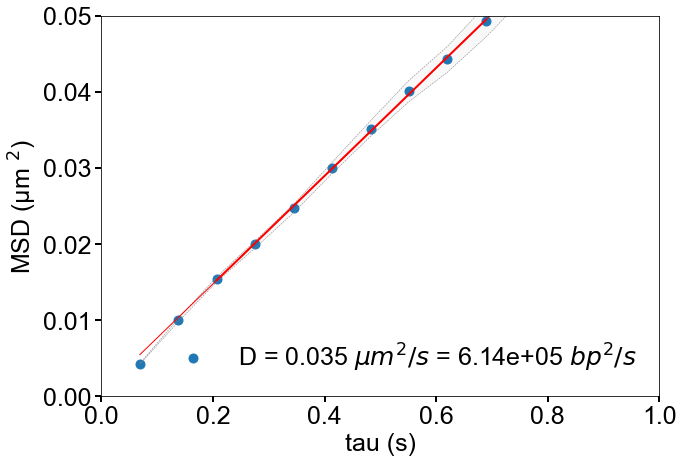

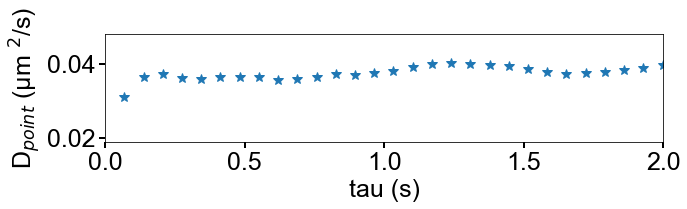

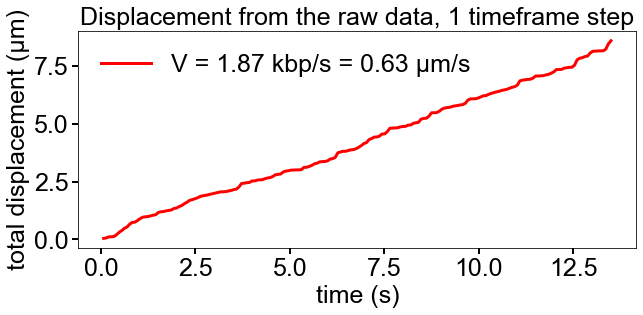

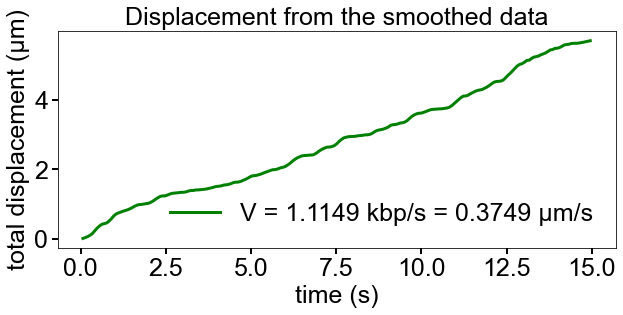

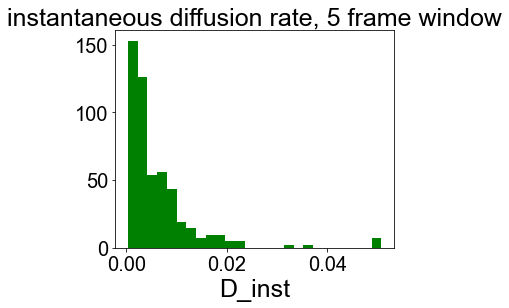

In [52]:
import statistics
## Calculate MSD and speed

N = len(pos)  # number of time frames (kymograph lines)

SqD = []      # vector of square displacement between two datapoints
MSD = []      # vector of mean square displacement for each time window
MSD_local = []
tau = []      # vector of time window (in seconds)
Dpoint = []   # MSD divided at each time window over 2n*dt (just to make a plot of it)
var_array = []
var_up = []
var_down = []
avg_window = 1



for n in range (1,N-3):        # probing different window sizes starting from n =1 (single linetime - dt) until N-1 (N-3 to be able to calculate variance of the last points)
    
    tau = np.append(tau,[n*line_time],axis=0)
    SqD = []
    
    for i in range (1,N-n):  # for each time window calculate square displacements between i and i+n frame
        
        SqD = np.append(SqD,[(pos[i+n]-pos[i])**2],axis=0)
        
        if n == 5:   #the instantaneous diffusion rate (moving average 5-frame window)
            srednia = ((pos[i+n]-pos[i+n-1])**2+(pos[i+n-1]-pos[i+n-2])**2+(pos[i+n-2]-pos[i+n-3])**2+(pos[i+n-3]-pos[i+n-4])**2+(pos[i+n-4]-pos[i+n-5])**2)/5
            MSD_local = np.append(MSD_local,[srednia/(2*n*line_time)],axis=0)
        
    MSD_point = np.sum(SqD)/(N-n)

    var = statistics.variance(SqD[:])
    
    MSD = np.append(MSD,[np.sum(SqD)/(N-n)],axis=0)   # calculate mean square displacement for each window size
    var_array = np.append(var_array,[var],axis=0)
    var_up = np.append(var_up,[MSD_point+ 0.5*var],axis=0)
    var_down = np.append(var_down,[MSD_point- 0.5*var],axis=0)
    Dpoint = np.append(Dpoint,[(np.sum(SqD)/(N-n))/(2*n*line_time)],axis=0)   # diffusion rate for individual point, later on global G comes from fitting the slope anyways



    
# Set the fitting window
window_min = 2
window_max = 10

p,q = np.polyfit(tau[window_min:window_max], MSD[window_min:window_max], 1)
#y = p*tau[window_min:window_max] + q
y = p*tau + q


bp_um = p*(1/0.00034)**2  

# Plot MSD 
fig, ax = plt.subplots(figsize=(10, 7)) 
ax.plot(tau,MSD,'o',markersize='9')
ax.plot(tau[0:150],var_up[0:150],'--',color='grey',linewidth=0.5)
ax.plot(tau[0:150],var_down[0:150],'--',color='grey',linewidth=0.5)
plt.fill_between(tau[0:150], var_down[0:150], var_up[0:150], facecolor="grey", alpha=0.05)
ax.plot(tau,y,'r',linewidth=1)
ax.plot(tau[window_min:window_max],y[window_min:window_max],'r',linewidth=2)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("MSD (\u03BCm $^{2}$)", fontsize=25)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+'.png', dpi=300, bbox_inches='tight')
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.05])
ax.legend(['D = ' + str(np.around(p/2,decimals =3))+' $\u03BCm^2/s$ = ' + "{:0.2e}".format(bp_um) + " $bp^2/s$"],fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/'+'MSD_' +'trace'+ str(trace)+ '_Kymo ' + (kymo_number[index])  +str(name[0:15]) +'.png', dpi=300, bbox_inches='tight')

np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSD_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau[window_min:window_max],MSD[window_min:window_max],y[window_min:window_max],var_array[window_min:window_max]], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'MSDfull_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[tau,MSD,y,var_array], delimiter=",")    # exports the peak position




# Plot D_local (measured at each time window)
fig, ax = plt.subplots(figsize=(10, 2)) 

ax.plot(tau,Dpoint,'*',markersize='10')
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("tau (s)", fontsize=25)
ax.set_ylabel("D$_{point}$ (\u03BCm $^{2}$/s)", fontsize=25)
ax.set_xlim([0, 2])
#ax.set_ylim([0, 2*p])



#########  Measure speed (total route divided by time) for raw data (shift between every time frame or manually selected averaging window) and smooth data


# Shifts between frames (MANUALLY AVERAGED POINTS, keep avg_wind = 1 to look at shift without averaging) 

shift_total = []
shift = []
shift_noabs = []
time_avg = []
avg_window = 1

averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
for i in range(1,np.int(np.round((N-20)/avg_window))-1):   
    
    averaged = np.mean(pos[:-1].reshape(-1, avg_window), axis=1)
    h = np.abs(averaged[i]-averaged[i-1])

    shift = np.append(shift,[h], axis =0)
    shift_total = np.append(shift_total,[np.sum(shift)],axis=0)

    time_avg = np.append(time_avg,[i*line_time*avg_window])



# Calculate the total route from the smoothed data

time_smooth = [] #it's a normal time but I generate a separate array for the smoothed datasate
shift_total2 = []
shift2 = []

for i in range(1,N):

    h2 = np.abs(pos_smooth[i]-pos_smooth[i-1])

    shift2 = np.append(shift2,[h2], axis =0)
    shift_total2 = np.append(shift_total2,[np.sum(shift2)],axis=0)
    
    time_smooth = np.append(time_smooth,[i*line_time],axis=0)



velocity = (shift_total[-1]/time_avg[-1])*2941.1764
velocity_smooth = (shift_total2[-1]/(N*line_time))*2941.1764    


    
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_avg,shift_total, linewidth=3.0, color = 'red')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the raw data, 1 timeframe step", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity/1000,decimals =2))+' kbp/s = '+ str(np.around(velocity/2974.1764,decimals =2)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_avg,shift_total], delimiter=",")    # exports the peak position


fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(time_smooth,shift_total2, linewidth=3.0, color = 'green')  
ax.tick_params(direction='out', length=6, width=2, labelsize= 25, grid_color='r', grid_alpha=0.5)
ax.set_xlabel("time (s)", fontsize=25)
ax.set_ylabel("total displacement (\u03BCm)", fontsize=25)
ax.set_title("Displacement from the smoothed data", fontsize=25)
ax.legend(['V = ' + str(np.around(velocity_smooth/1000,decimals =4))+' kbp/s = '+ str(np.around(velocity_smooth/2974.1764,decimals =4)) + ' \u03BCm/s'], fontsize=25, frameon=False)
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'Speed_SGsmooth_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', np.c_[time_smooth,shift_total2], delimiter=",")    # exports the peak position

fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(MSD_local, linewidth=3.0, color = 'green')  

plt.hist(MSD_local, bins = 'auto', density=True,color='g') 
#plt.xlim(0,0.6)
plt.xlabel('D_inst')
plt.title('instantaneous diffusion rate, 5 frame window')
plt.savefig('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'instantaneous_diffusion_rate_' +'trace'+str(trace) + '_Kymo' + (kymo_number[index]) +str(name[0:15]) + '.csv', MSD_local, delimiter=",")    # exports the peak position



## Single frame shift distribution

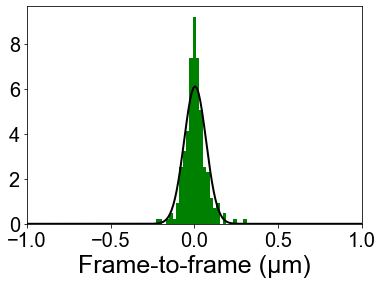

In [53]:
mu = []
std = []
shift_noabs = []
for i in range(1,N-1):                    # looping through each column
     
    shift_noabs = np.append(shift_noabs,[pos[i] - pos[i-1]], axis =0)

    
plt.hist(shift_noabs,bins='auto', stacked=True, density=True, color='g') 
plt.xlim([-1,1])
from scipy.stats import norm


# Fit a normal distribution to the data:
mu, std = norm.fit(shift_noabs)


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-1, 1, 200)
prob = norm.pdf(x, mu, std)
plt.plot(x, prob, 'k', linewidth=2)
#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#plt.title(title)
plt.xlabel('Frame-to-frame (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'PDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftNoAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position


plt.show()





Gaussian fit results: center = 0.00,  width = 0.07
Exponential fit results: center = 0.00,  var = 0.05


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


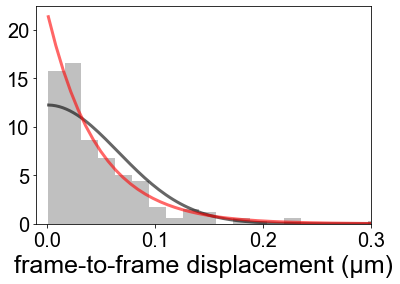

In [54]:
shift_abs = []

for i in range(1,N-1):                    # looping through each column
     
    shift_abs = np.append(shift_abs,[abs(pos[i] - pos[i-1])], axis =0)
    
weights = np.ones_like(shift_abs) / len(shift_abs)
plt.hist(shift_abs,bins='auto',stacked=True, density=True, color='silver') 
plt.xlim([-0.01,0.3])
#plt.ylim([-0.02,7])

# Fit a normal distribution to the data:
#mu, std = halfnorm.fit(shift_abs)


from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import expon
mu = []
std = []
mu_exp = []
var_exp = []

# Fit a normal distribution to the data:
mu, std = halfnorm.fit(shift_abs)
mu_exp, var_exp = expon.fit(shift_abs)

x = np.linspace(halfnorm.ppf(0.001), halfnorm.ppf(0.999), 1000)
x2 = np.linspace(expon.ppf(0.001),  expon.ppf(0.999), 1000)

prob2 = halfnorm.pdf(x,mu,std)
prob_exp = expon.pdf(x2,mu_exp,var_exp)

plt.plot(x, prob2,'k-', lw=3, alpha=0.6, label='halfnorm pdf')
plt.plot(x2, prob_exp,'r-', lw=3, alpha=0.6, label='expon pdf')

print('Gaussian fit results: center = %.2f,  width = %.2f' % (mu, std))
print('Exponential fit results: center = %.2f,  var = %.2f' % (mu_exp, var_exp))


#title = "Fit results: center = %.2f,  width = %.2f" % (mu, std)
#title = "Gaussian vs. exponential distribution"
#plt.title(title)
#plt.legend('data','Guassian fit','Expenential fit')


plt.xlabel('frame-to-frame displacement (\u03BCm)')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15])+ '.png', dpi=300, bbox_inches='tight')
plt.savefig('Single-particle tracking' +'/' +'Trace'+ str(trace)+ '/'  +'HalfPDF_' +'trace_'+ str(trace)+ '_Kymo ' + (kymo_number[index]) + str(name[0:15]) +'.eps', dpi=300, bbox_inches='tight')


np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'PDF_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', np.c_[x,prob2], delimiter=",")    # exports the peak position
np.savetxt('Single-particle tracking' +'/'+'Trace'+ str(trace)+ '/' +'ShiftAbs_' +'trace'+str(trace)+'_Kymo' + (kymo_number[index]) + str(name[0:15]) +'.csv', shift_noabs, delimiter=",")    # exports the peak position

plt.show()